In [ ]:
%pip install pymysql

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import os
import pymysql
import pandas as pd
import numpy as np

succeess = False

while not succeess:
  try:
    conn = pymysql.connect(
        host='db-aff.cpapv35x7rsh.us-east-2.rds.amazonaws.com',
        port=int(3306),
        user="admin",
        passwd="olist2021",
        db='olist',
        charset='utf8mb4')
    db = conn.cursor()
    succeess = True
  except:
    print("Wrong Password")

print("Connection Made")


def add_quotes(s):
  return '"'+str(s)+'",'

def add_quotes_nocomma(s):
  return '"'+str(s)+'"'

     |████████████████████████████████| 43 kB 1.0 MB/s 
Connection Made


In [ ]:
# Importing the required libraries
import pandas as pd
pd.set_option('display.max_columns', 50) # Display up to 50 columns at a time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
plt.style.use('seaborn')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,5
import glob # To read all csv files in the directory
import seaborn as sns
import calendar

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_precision_recall_curve
from sklearn.metrics import make_scorer, precision_recall_curve, classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
import statsmodels.api as sm


In [ ]:
import time

In [ ]:
customers = pd.read_sql_query("select * from olist.customers", conn)
order_details = pd.read_sql_query("select * from olist.order_details", conn)
products = pd.read_sql_query("select * from olist.products", conn)
sellers = pd.read_sql_query("select * from olist.sellers", conn)
reviews = pd.read_sql_query("select * from olist.reviews", conn)[['review_id', 'order_id', 'score', 'message']]
orders = pd.read_sql_query("select * from olist.orders", conn)#.drop(columns=['customer_id', 'order_status'])
product_cat = pd.read_sql_query("select * from olist.product_categories", conn)

In [ ]:
#Load payments table separately:
from google.colab import files
uploaded = files.upload()

Saving olist_order_payments_dataset.csv to olist_order_payments_dataset.csv


In [ ]:
import io
payments = pd.read_csv(io.BytesIO(uploaded['olist_order_payments_dataset.csv']))
# Dataset is now stored in a Pandas Dataframe

# Order Details

In [ ]:
order_details.info()
#['order_id','product_id'] is the compound key

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             102425 non-null  object        
 1   product_id           102425 non-null  object        
 2   seller_id            102425 non-null  object        
 3   shipping_limit_date  102425 non-null  datetime64[ns]
 4   qty                  102425 non-null  float64       
 5   price                102425 non-null  float64       
 6   freight_value        102425 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 5.5+ MB


In [ ]:
#check orders with multiple product_id
test = order_details.groupby('order_id')['product_id'].count().reset_index()
test.sort_values(by='product_id', ascending=False)

,order_id,product_id
77909,ca3625898fbd48669d50701aba51cd5f,8
48309,7d8f5bfd5aff648220374a2df62e84d5,7
46116,77df84f9195be22a4e9cb72ca9e8b4c2,7
66653,ad850e69fce9a512ada84086651a2e7d,7
36443,5efc0b7fe9df7f0c567404abaa4d25fc,6
...,...,...
33440,56d0a27ec26d1644336aff1ec939c089,1
33439,56d01e37808556640e75a40c8202b0a8,1
33438,56ce64b53ec3bb5b0525f21506619f8e,1
33437,56ce3873eb6d633a47581ec221f50a65,1


In [ ]:
#check to see if there are any duplicate orders
order_details[order_details.duplicated(subset=['order_id','product_id'])==True].shape[0]
#no duplicate key/order

0

# Payments

In [ ]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [ ]:
payments.order_id.groupby([payments.payment_type, 
                           payments.payment_installments]).size()

payment_type  payment_installments
boleto        1                       19784
credit_card   0                           2
              1                       25455
              2                       12413
              3                       10461
              4                        7098
              5                        5239
              6                        3920
              7                        1626
              8                        4268
              9                         644
              10                       5328
              11                         23
              12                        133
              13                         16
              14                         15
              15                         74
              16                          5
              17                          8
              18                         27
              20                         17
              21                         

In [ ]:
# collapse payment_sequential and one-hot encode payments prior to merge
payments_cat = pd.get_dummies(payments, columns = ['payment_type'])
  #group by orderid - so 1 row is 1 order. dummies indicating whether that payment typed is used nor not
payments_grp = payments_cat.groupby(by=['order_id'], as_index=False)\
                                    .agg(payment_total=('payment_value', 'sum'), 
                                         payment_count=('payment_sequential', 'count'), 
                                         payment_boleto=('payment_type_boleto', 'max'),
                                         payment_cc=('payment_type_credit_card', 'max'),
                                         payment_voucher=('payment_type_voucher', 'max'),
                                         payment_debit=('payment_type_debit_card', 'max')
                                     )
cols = ['payment_count', 'payment_boleto', 'payment_cc', 'payment_voucher', 'payment_debit']
payments_grp[cols] = payments_grp[cols].astype('int64') #change type to integer
payments_grp.describe()

,payment_total,payment_count,payment_boleto,payment_cc,payment_voucher,payment_debit
count,99440.000000,99440.000000,99440.000000,99440.000000,99440.000000,99440.000000
mean,160.990267,1.044710,0.198954,0.769358,0.038878,0.015366
std,221.951257,0.381166,0.399215,0.421246,0.193304,0.123004
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,62.010000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,105.290000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,176.970000,1.000000,0.000000,1.000000,0.000000,0.000000
max,13664.080000,29.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
payments_grp.head(3)

,order_id,payment_total,payment_count,payment_boleto,payment_cc,payment_voucher,payment_debit
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,1,0,1,0,0
1,00018f77f2f0320c557190d7a144bdd3,259.83,1,0,1,0,0
2,000229ec398224ef6ca0657da4fc703e,216.87,1,0,1,0,0


In [ ]:
# check for duplicate payment orders. there is no duplicates for order_id
payments_grp[payments_grp.duplicated(subset=['order_id'])==True].shape[0]

0

# Products & Product Category

In [ ]:
products.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_length         32951 non-null  float64
 3   product_description_length  32951 non-null  float64
 4   product_photos_qty          32951 non-null  float64
 5   product_weight_gm           32951 non-null  float64
 6   product_length_cm           32951 non-null  float64
 7   product_height_cm           32951 non-null  float64
 8   product_width_cm            32951 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [ ]:
product_complete = pd.merge(products, product_cat, on='product_category_name', how = 'left')

In [ ]:
#add english name for category, some NaN was not translated so I looked it up
product_complete.loc[product_complete['product_category_name']=='pc_gamer', 'product_category_name_eng'] = 'pc_gamer'
product_complete.loc[product_complete['product_category_name']=='portateis_cozinha_e_preparadores_de_alimentos', 'product_category_name_eng'] = 'kitchen_dining_laundry_garden_furniture'
product_complete[product_complete.isnull().any(axis=1)].product_category_name.unique()

array(['nan'], dtype=object)

In [ ]:
product_complete = product_complete.drop(columns=['product_weight_gm', 'product_length_cm', 'product_height_cm', 'product_width_cm'])
product_complete.head(3)

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_category_name_eng
0,00066f42aeeb9f3007548bb9d3f33c38,perfumaria,53.0,596.0,6.0,perfumery
1,00088930e925c41fd95ebfe695fd2655,automotivo,56.0,752.0,4.0,auto
2,0009406fd7479715e4bef61dd91f2462,cama_mesa_banho,50.0,266.0,2.0,bed_bath_table


# Sellers

In [ ]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [ ]:
sellers['seller_zip_code_prefix'] = sellers['seller_zip_code_prefix'].apply(str)
sellers.describe()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095,3095,3095
unique,3095,2246,611,23
top,da2782c804606d2a5d8e1760dbb3e7ec,14940,sao paulo,SP
freq,1,49,694,1849


## **Reviews**
There are orders with multiple reviews, but this means that the customer fills out the survey multiple times, NOT that multiple reviews are for multiple products. I checked and there are orders with multiple products but only 1 review.
Hence, to evaluate features associated with review scores, we should look at properties of the whole order, not for specific products.

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  99224 non-null  object
 1   order_id   99224 non-null  object
 2   score      99224 non-null  int64 
 3   message    99224 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [ ]:
# check for multiple reviews on same order
  #547 orders with multiple reviews
len(reviews[reviews.duplicated(subset=['order_id'], 
                keep=False)].groupby('order_id'))
  #out of 98673 unique order ids   
reviews.order_id.nunique()

#this means that they update their review multiple times

98673

### Each order should have only 1 review/ review score

Each order is associated with 1 review_id (1 order cannot have 2 review_ids). But one review_id can be associated with multiple orders.This could mean that they submit multiple orders at the same time and write one review for all orders.


In [ ]:
#Ideally want to retain the most recent review_id, but we dont know which one is that, so just drop duplicate randomly.
reviews = reviews.drop_duplicates(subset=['order_id'])
len(reviews)

98673

In [ ]:
# check for multiple reviews
    #0 orders with multiple review
len(reviews[reviews.duplicated(subset=['order_id'], 
                            keep=False)].groupby('order_id'))
    #out of 98673 unique orders
reviews.order_id.nunique()
#98102 unique reviews
#98673 unique orders

98673

# **Merge Tables**

In [ ]:
len(order_details)

102425

In [ ]:
#['order_id','product_id'] is unique for each row in order_details
order_details.groupby(['order_id','product_id']).ngroups

102425

There are orders in 'orders' table that are not in 'order details' table. Hence left join by 'order details' table so that we have info on price, freight, etc. on each order.


In [ ]:
#left join orders and order_details, there is no NA
  #note that 'orders' include only 'delivered' orders
all_orders = pd.merge(order_details, orders, on='order_id',how='left')
all_orders.head(5)
#102425
#all_orders[all_orders.isnull().any(axis=1)]
  #checked, no NA values

#take only orders with status 'delivered':
delivered_orders = all_orders[all_orders['order_status']=='delivered']
len(all_orders)
len(delivered_orders)

100196

In [ ]:
# combine and flatten tables
df = pd.merge(left=delivered_orders, right=customers, how='inner', left_on='customer_id', right_on='customer_id')
   #checked, no NA
df = pd.merge(left=df, right=product_complete, how='inner', left_on='product_id', right_on='product_id')
  #checked, no NA

df = pd.merge(left=df, right=payments_grp, how='inner', left_on='order_id', right_on='order_id')
  #checked, no NA
  
df = pd.merge(left=df, right=sellers, how='inner', left_on='seller_id', right_on='seller_id')
  #checked, no NA

df = pd.merge(left=df, right=reviews, how='inner', left_on='order_id', right_on='order_id')


In [ ]:
df.review_id.nunique()

95348

In [ ]:
# check order status distribution, only interested in delivered order reviews
df.order_status.value_counts()

delivered    99502
Name: order_status, dtype: int64

In [ ]:
print(str(df.shape[0])+' rows in final filtered merged df')

99502 rows in final filtered merged df


# **Data Processing**


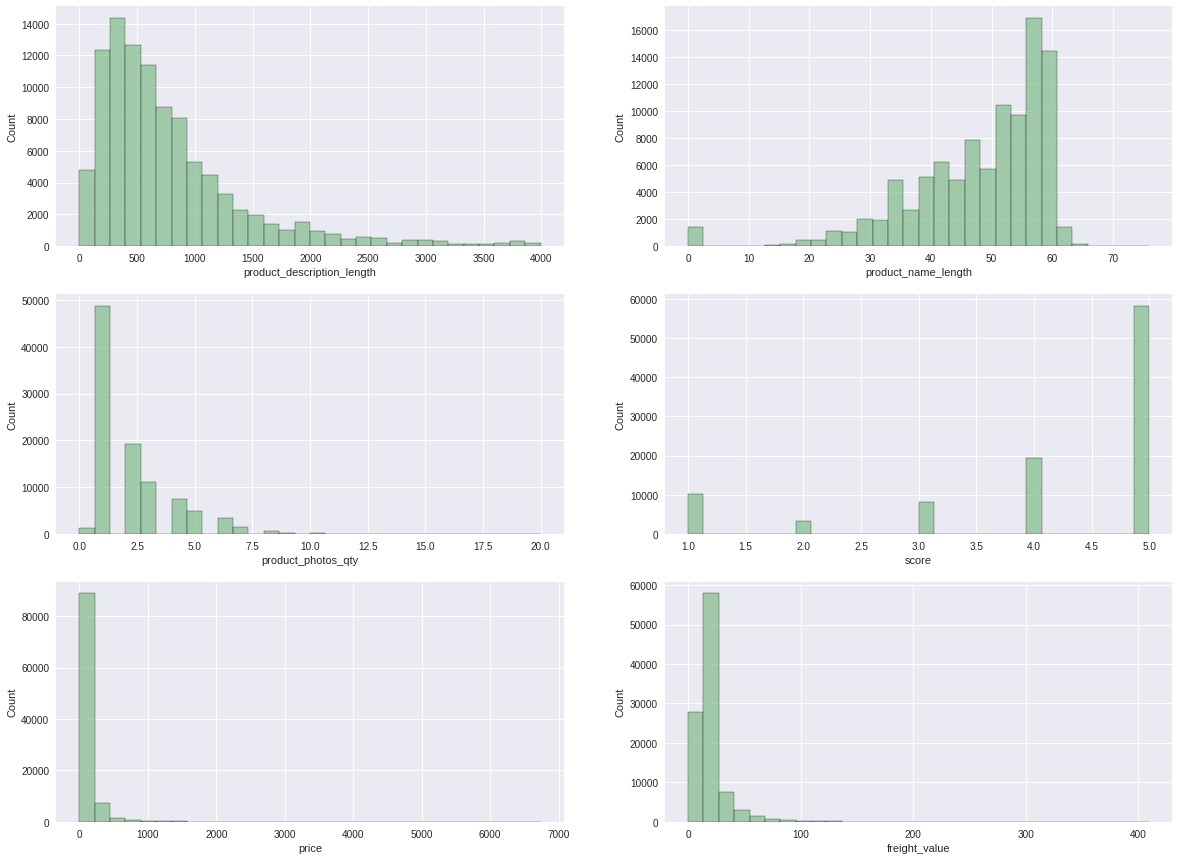

In [ ]:
#check distribution of some variables:

# Draw Plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,15))
sns.histplot(data=df, ax=ax1,x='product_description_length',color='#86bf91', bins=30)
sns.histplot(data=df, ax=ax2,x='product_name_length',color='#86bf91',bins=30)
sns.histplot(data=df, ax=ax3,x='product_photos_qty',color='#86bf91',bins=30)
sns.histplot(data=df, ax=ax4,x='score',color='#86bf91',bins=30)
sns.histplot(data=df, ax=ax5,x='price',color='#86bf91',bins=30)
sns.histplot(data=df, ax=ax6,x='freight_value',color='#86bf91',bins=30)

In [ ]:
#distribution of customers by state
customer_state_pct = df['customer_state'].value_counts(normalize=True).reset_index()
customer_state_pct.columns.values[1]='customer_dist'
customer_state_pct

,index,customer_dist
0,SP,0.421328
1,RJ,0.127404
2,MG,0.117726
3,RS,0.055547
4,PR,0.050833
5,SC,0.036572
6,BA,0.033638
7,DF,0.021648
8,ES,0.020492
9,GO,0.020412


In [ ]:
#distribution of sellers by state
seller_state_pct = df['seller_state'].value_counts(normalize=True).reset_index()
seller_state_pct.columns.values[1]='seller_dist'
seller_state_pct

,index,seller_dist
0,SP,0.710930
1,MG,0.079144
2,PR,0.077003
3,RJ,0.042743
4,SC,0.036773
5,RS,0.019819
6,DF,0.008151
7,BA,0.005528
8,GO,0.004703
9,PE,0.004060


In [ ]:
df['product_category_name_eng'].value_counts(normalize=True)

bed_bath_table               0.100906
health_beauty                0.089501
sports_leisure               0.077677
computers_accessories        0.068188
furniture_decor              0.067087
                               ...   
la_cuisine                   0.000122
cds_dvds_musicals            0.000122
pc_gamer                     0.000071
fashion_childrens_clothes    0.000071
security_and_services        0.000020
Name: product_category_name_eng, Length: 72, dtype: float64

In [ ]:
df['payment_count'].value_counts(normalize=True)

1     0.970101
2     0.023979
3     0.003126
4     0.001075
5     0.000543
6     0.000382
7     0.000281
8     0.000101
12    0.000090
11    0.000080
9     0.000070
10    0.000040
13    0.000030
14    0.000020
15    0.000020
19    0.000020
21    0.000020
22    0.000010
26    0.000010
Name: payment_count, dtype: float64

In [ ]:
#20% use boleto
df['payment_boleto'].value_counts(normalize=True)

0    0.801873
1    0.198127
Name: payment_boleto, dtype: float64

In [ ]:
#77% use credit card
df['payment_cc'].value_counts(normalize=True)

1    0.7711
0    0.2289
Name: payment_cc, dtype: float64

In [ ]:
#1.5% all orders use debit 
df['payment_debit'].value_counts(normalize=True)

0    0.984523
1    0.015477
Name: payment_debit, dtype: float64

In [ ]:
#3.8% all orders use vouchers 
df['payment_voucher'].value_counts(normalize=True)

0    0.962011
1    0.037989
Name: payment_voucher, dtype: float64

In [ ]:
df['score'].value_counts(normalize=True)

5    0.585827
4    0.194800
1    0.103887
3    0.083365
2    0.032120
Name: score, dtype: float64

# **Date Times:**

Converting **order_approved_at, order_delivered_carrier_date, order_delivered_customer_date** into date time columns

remove NA values from orders table and converting them to datetime columns. 
NA values exists in form of '0000-00-00 00:00:00'.

In [ ]:
navalue = '0000-00-00 00:00:00' #reviews_orders_df.iloc[89, :]['order_delivered_customer_date']
cols = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']
indices = np.array([True] * df.shape[0])
for col in cols:
  ix_here = df[col].apply(lambda x: False if x == navalue else True)
  indices = indices & ix_here

df = df[indices]
for col in cols:
  df.loc[:, col] = pd.to_datetime(df.loc[:, col])
#removed 23 rows with NA values for date variables
print("NA value is :- ", navalue)
print("Number of data points containing NA values ", df.shape[0] - df.shape[0])


NA value is :-  0000-00-00 00:00:00
Number of data points containing NA values  0


Generating **is_delay**, a new feature that says whether the order was delivered before the estimated delivery date or not. Also get day, month, hour of purchase.

In [ ]:
df['is_delay'] = df['order_delivered_customer_date'] > df['order_estimated_delivery_date']
#make it an int variable instead of boolean
df['is_delay']= df['is_delay'].map(lambda x: 1 if x == True else 0)
#df['order_purchase_month'] = df['order_purchase_timestamp'].apply(lambda x: x.month)
#df['order_purchase_day'] = df['order_purchase_timestamp'].apply(lambda x: x.day)
df['buy_day']=df['order_purchase_timestamp'].dt.day_name()
df['buy_hour'] = df['order_purchase_timestamp'].dt.hour # Extracting hour from deadline


# **Order-based Price Measures**

Current 'df' shows price, freight_value for each product, and qty = number of (same product_id) in that order. As mentioned before, since the review_score is associated with each order, we want to derive price **features that represent the whole order, not each product in that order.**

In [ ]:
df['total_price'] = df['qty']*df['price']
df['total_freight'] = df['qty']*df['freight_value']

In [ ]:
# create order-based aggregate measures: total items in an order, total unique sellers, total price for items, total freight, and average price per item
order_ct = df.groupby('order_id').agg(order_item_ct=('qty', 'sum'),
                                            order_seller_ct=('seller_id', 'nunique'),
                                            order_value=('total_price', 'sum'),
                                            order_freight=('total_freight', 'sum')).reset_index()
order_ct['order_avg_price']=order_ct['order_value']/order_ct['order_item_ct']
order_ct.sort_values(by='order_item_ct',ascending=False)                                    
#order_average price is average price per item

df = pd.merge(left=df, right=order_ct, how='inner', left_on='order_id', right_on='order_id')

#can actually drop qty, price, freight_value now

In [ ]:
#check large orders to see if the calculations are correct) (YES)
df.sort_values(by='order_item_ct', ascending=False).head(1)

df[df['order_id']=="8272b63d03f5f79c56e9e4120aec44ef"]

,order_id,product_id,seller_id,shipping_limit_date,qty,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_length,product_description_length,product_photos_qty,product_category_name_eng,payment_total,payment_count,payment_boleto,payment_cc,payment_voucher,payment_debit,seller_zip_code_prefix,seller_city,seller_state,review_id,score,message,is_delay,buy_day,buy_hour,total_price,total_freight,order_item_ct,order_seller_ct,order_value,order_freight,order_avg_price
45551,8272b63d03f5f79c56e9e4120aec44ef,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,10.0,1.2,7.89,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,beleza_saude,45.0,231.0,3.0,health_beauty,196.11,1,0,1,0,0,3813,sao paulo,SP,e8236fe7b6e1bdd513a500de361e2b87,1,Eu estou tentando cancelar faz tempo devido o ...,1,Sunday,18,12.0,78.90,21.0,1,31.8,164.37,1.514286
45552,8272b63d03f5f79c56e9e4120aec44ef,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,10.0,1.2,7.89,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,beleza_saude,45.0,232.0,3.0,health_beauty,196.11,1,0,1,0,0,3813,sao paulo,SP,e8236fe7b6e1bdd513a500de361e2b87,1,Eu estou tentando cancelar faz tempo devido o ...,1,Sunday,18,12.0,78.90,21.0,1,31.8,164.37,1.514286
45553,8272b63d03f5f79c56e9e4120aec44ef,79ce45dbc2ea29b22b5a261bbb7b7ee7,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.0,7.8,6.57,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,beleza_saude,27.0,152.0,2.0,health_beauty,196.11,1,0,1,0,0,3813,sao paulo,SP,e8236fe7b6e1bdd513a500de361e2b87,1,Eu estou tentando cancelar faz tempo devido o ...,1,Sunday,18,7.8,6.57,21.0,1,31.8,164.37,1.514286


### **The dependent variable will now be converted into 1s (good reviews) and 0s (bad reviews)**


In [ ]:
#review sentiment: 0 is negative (1,2,3 score), 1 is positive (4,5 score)
df['review_sentiment'] = df['score'].apply(lambda x: 0 if (x < 4) else 1)

A customer may give good reviews for more popular products. We created variable **counts of orders that product is in**

In [ ]:

# calculate % of positive order for sellers and products, and counts of orders that product is in
#seller_pos = df.groupby('seller_id').agg(seller_pos_pct =('review_sentiment','mean')).reset_index()
#df = pd.merge(df, seller_pos, how='inner', left_on='seller_id', right_on='seller_id')
product_order_ct = df.groupby('product_id').agg(product_order_ct = ('order_id', 'count')).reset_index()
product_order_ct
df = pd.merge(df, product_order_ct, how='inner', left_on='product_id', right_on='product_id')

In [ ]:
# Calculate interval features:
#delivery time = delivery date - purchase datefrom datetime import date
df['delivery_days']=(df.order_delivered_customer_date-df.order_purchase_timestamp).dt.days
#time from purchase to order approval
df['approval_days'] = (df.order_approved_at-df.order_purchase_timestamp).dt.days

## **Data Visualization**

is_delay and review score

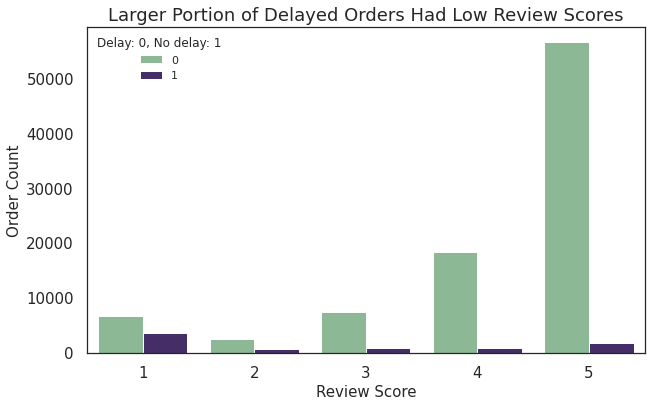

In [ ]:
#delivered_orders['is_delay'] = np.where(delivered_orders['est_real_delivery_days']<0, True, False) 
#from google.colab import files
#import matplotlib.pyplot as plt
#import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style("white")
sns.countplot(x='score', hue='is_delay', data=df, palette=['#86bf91','#432371'])
plt.xlabel('Review Score', fontsize=15)
plt.ylabel('Order Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Larger Portion of Delayed Orders Had Low Review Scores', fontsize=18)

plt.legend(title="Delay: 0, No delay: 1",title_fontsize=12,fancybox=True)


delivery_days, approval_days and review score


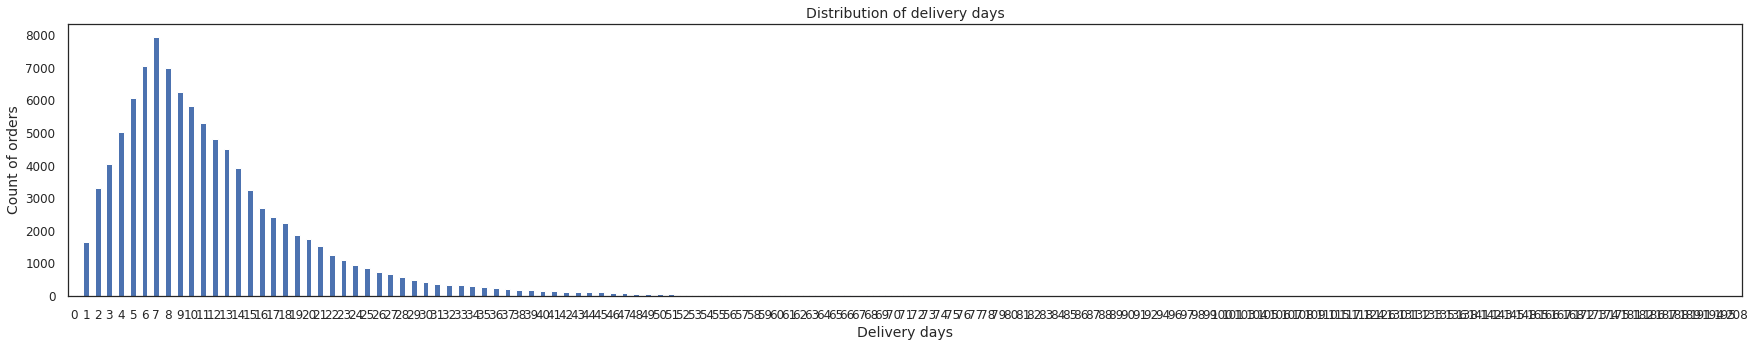

In [ ]:
#delivery time = delivery date - purchase datefrom datetime import date
#mean=23, 75%=28

df.groupby(by='delivery_days').size().plot.bar(figsize=(30,5))
plt.xticks(rotation = 0)
plt.xlabel('Delivery days', fontsize=14)
plt.ylabel('Count of orders', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of delivery days', fontsize=14)
plt.show()



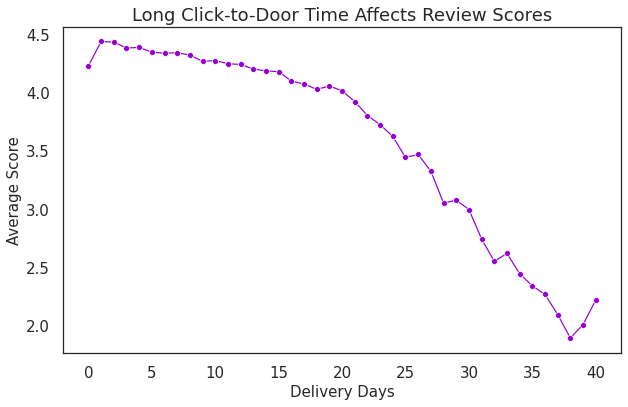

In [ ]:
#distribution of delivery_days is highly right skewed, so only take 40 days and below:
fig, ax = plt.subplots(figsize=(10, 6))

deliverydays_40 = df[df['delivery_days']<=40]
deliverydays_40 = deliverydays_40.groupby('delivery_days')['score'].mean().reset_index()

sns.lineplot(x="delivery_days", y="score", data=deliverydays_40, marker="o", color='darkviolet', linewidth=1.2)
#plt.plot("delivery_days", "score", data=deliverydays_40, marker='x')
ax.set_title('Long Click-to-Door Time Affects Review Scores', fontsize=18)
ax.set_ylabel('Average Score', fontsize=15)
ax.set_xlabel('Delivery Days', fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
plt.show()




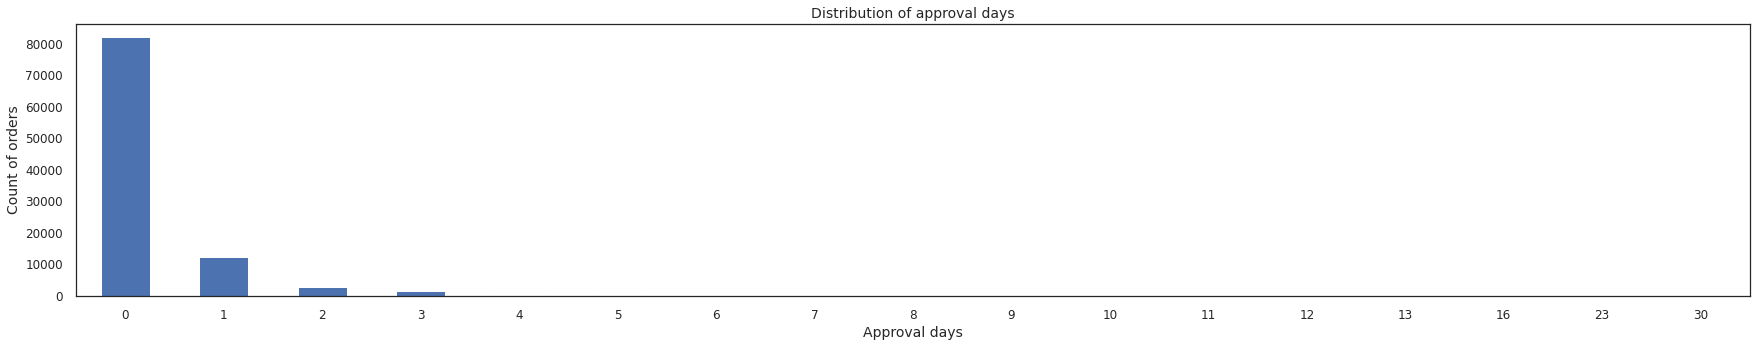

In [ ]:
#approval time

df.groupby(by='approval_days').size().plot.bar(figsize=(30,5))
plt.xticks(rotation = 0)
plt.xlabel('Approval days', fontsize=14)
plt.ylabel('Count of orders', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of approval days', fontsize=14)
plt.show()

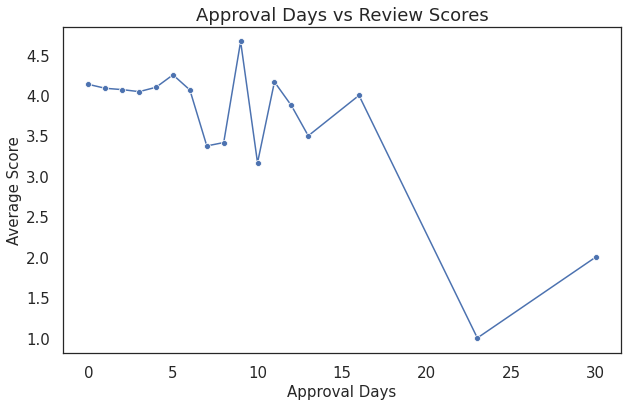

In [ ]:
#distribution of delivery_days is highly right skewed, so only take 40 days and below:
fig, ax = plt.subplots(figsize=(10, 6))

df_approval = df.groupby('approval_days')['score'].mean().reset_index()
df_approval

sns.lineplot(x="approval_days", y="score", data=df_approval, marker="o")
ax.set_title('Approval Days vs Review Scores', fontsize=18)
ax.set_ylabel('Average Score', fontsize=15)
ax.set_xlabel('Approval Days', fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
plt.show()

There does not seem to be a relationship between days from purchase to approval, and review scores

In [ ]:
df['days_variance'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
df['days_late'] = df['days_variance'].map(lambda x: x if x > 0 else 0)
#only 6% of all orders are late
len(df[df['days_late']>0])/len(df)

0.06534042360699244

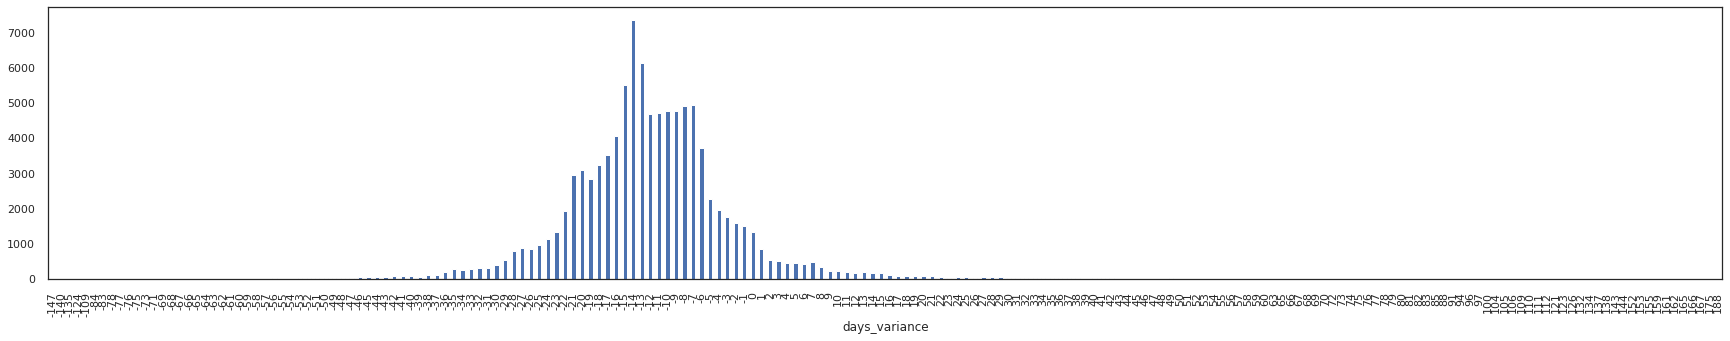

In [ ]:
df.groupby(by='days_variance').size().plot.bar(figsize=(30,5))

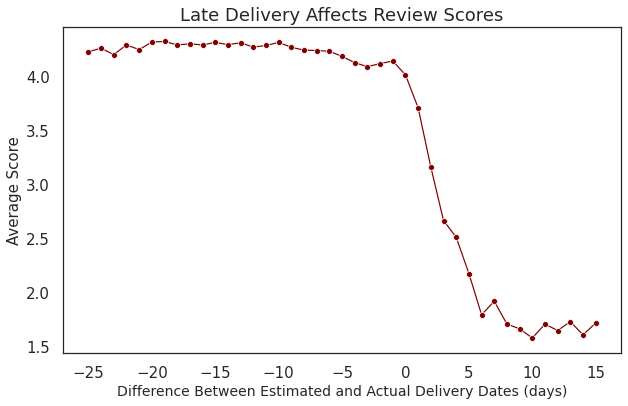

In [ ]:
#LATE DELIVERY REALLY AFFECTS SCORES
df_delay = df[(df['days_variance']>=-25)&(df['days_variance']<=15)]
df_delay = df_delay.groupby('days_variance')['score'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x="days_variance", y="score", data=df_delay, marker="o",color='maroon', linewidth=1.2)
ax.set_title('Late Delivery Affects Review Scores', fontsize=18)
ax.set_ylabel('Average Score', fontsize=15)
ax.set_xlabel('Difference Between Estimated and Actual Delivery Dates (days)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
plt.show()

photo qty, name length, desc length and review score
not much pattern

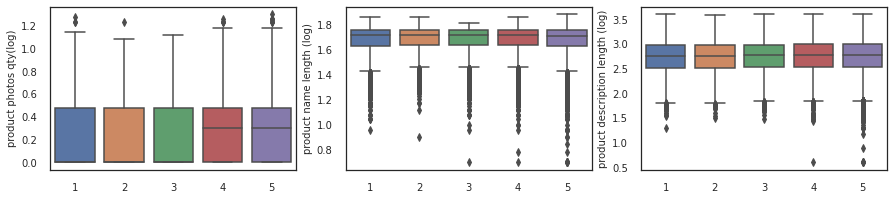

In [ ]:
fig, ((ax1, ax2,ax3)) = plt.subplots(1,3, figsize=(15,3))
sns.boxplot(x="score",y=np.log10(df.product_photos_qty),data=df,ax=ax1)
sns.boxplot(x="score",y=np.log10(df.product_name_length),data=df, ax=ax2)
sns.boxplot(x="score",y=np.log10(df.product_description_length),data=df, ax=ax3)

#ax3.set_title('Number of bed_bath_table orders made by month', fontsize=14)
ax3.set_ylabel('product description length (log)', fontsize=10)
ax3.set_xlabel('')
ax3.xaxis.set_tick_params(labelsize=10)
ax3.yaxis.set_tick_params(labelsize=10)

ax2.set_ylabel('product name length (log)', fontsize=10)
ax2.set_xlabel('')
ax2.xaxis.set_tick_params(labelsize=10)
ax2.yaxis.set_tick_params(labelsize=10)

ax1.set_ylabel('product photos qty(log)', fontsize=10)
ax1.set_xlabel('')
ax1.xaxis.set_tick_params(labelsize=10)
ax1.yaxis.set_tick_params(labelsize=10)

In [ ]:
fig
df_photos = df.groupby('score')['product_photos_qty'].mean().reset_index()
df_name = df.groupby('score')['product_name_length'].mean().reset_index()
df_desc = df.groupby('score')['product_description_length'].mean().reset_index()

sns.barplot(x="score",y="product_photos_qty",data=df_photos,ax=ax1)
sns.barplot(x="score",y="product_name_length",data=df_name, ax=ax2)
sns.barplot(x="score",y="product_description_length",data=df_desc, ax=ax3)

#ax3.set_title('Number of bed_bath_table orders made by month', fontsize=14)
ax3.set_ylabel('avg product description length', fontsize=10)
ax3.set_xlabel('')
ax3.xaxis.set_tick_params(labelsize=10)
ax3.yaxis.set_tick_params(labelsize=10)

ax2.set_ylabel('avg product name length', fontsize=10)
ax2.set_xlabel('')
ax2.xaxis.set_tick_params(labelsize=10)
ax2.yaxis.set_tick_params(labelsize=10)

ax1.set_ylabel('avg product photos qty', fontsize=10)
ax1.set_xlabel('')
ax1.xaxis.set_tick_params(labelsize=10)
ax1.yaxis.set_tick_params(labelsize=10)

state and review score

In [ ]:
by_state=df.groupby('customer_state').agg(pos_review_pct=('review_sentiment','mean'),
                                 delivery_days=('delivery_days','mean'),
                                 late_order_pct=('is_delay','mean'),
                                 order_count=('order_id','count'),
                                 total_sale = ('order_value', 'sum'),
                                 score = ('score', 'mean')).reset_index()
by_state= pd.merge(by_state, customer_state_pct, left_on='customer_state', right_on='index', how = 'left')
by_state= pd.merge(by_state, seller_state_pct, left_on='customer_state', right_on='index', how = 'left')
by_state = by_state.drop(columns=['index_x','index_y'])

In [ ]:
by_state.to_csv('by_state.csv')

In [ ]:
by_state.sort_values(by='delivery_days',ascending=False)

,customer_state,pos_review_pct,delivery_days,late_order_pct,order_count,total_sale,score,customer_dist,seller_dist
21,RR,0.682927,28.975610,0.121951,41,7.057470e+03,3.902439,0.000412,NaN
3,AP,0.811594,28.724638,0.057971,69,1.385151e+04,4.217391,0.000693,NaN
2,AM,0.817568,25.918919,0.047297,148,2.284142e+04,4.216216,0.001487,0.000030
1,AL,0.709677,23.759305,0.230769,403,7.947150e+04,3.833747,0.004050,NaN
13,PA,0.718588,23.145379,0.117342,963,1.807368e+05,3.894081,0.009678,0.000080
24,SE,0.721408,20.865103,0.146628,341,5.738918e+04,3.900293,0.003427,0.000090
9,MA,0.686062,20.837618,0.192152,739,1.330449e+05,3.780785,0.007437,0.003920
0,AC,0.740741,20.604938,0.037037,81,1.630067e+04,4.061728,0.000814,NaN
5,CE,0.720611,20.586260,0.149618,1310,2.302709e+05,3.915267,0.013176,0.000874
14,PB,0.752852,19.726236,0.104563,526,1.145465e+05,4.049430,0.005286,0.000352


order value, order freight and order avg price vs review score

In [ ]:
by_order = df.groupby('order_id').agg(order_value=('order_value','mean'),
                            order_freight=('order_freight','mean'),
                              order_avg_price=('order_avg_price','mean'),
                                order_item_ct =('order_item_ct','mean'),
                                score = ('score','mean')).reset_index()

by_order.sort_values(by='order_item_ct', ascending=False)

by_order['freight_ratio'] = by_order['order_freight']/by_order['order_value']
by_order

,order_id,order_value,order_freight,order_avg_price,order_item_ct,score,freight_ratio
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,58.90,1.0,5,0.225637
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,239.90,1.0,4,0.083076
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,199.00,1.0,5,0.089799
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,12.99,1.0,4,0.984604
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,199.90,1.0,5,0.090745
...,...,...,...,...,...,...,...
95803,fffc94f6ce00a00581880bf54a75a037,299.99,43.41,299.99,1.0,5,0.144705
95804,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53,350.00,1.0,5,0.104371
95805,fffce4705a9662cd70adb13d4a31832d,99.90,16.95,99.90,1.0,5,0.169670
95806,fffe18544ffabc95dfada21779c9644f,55.99,8.72,55.99,1.0,5,0.155742


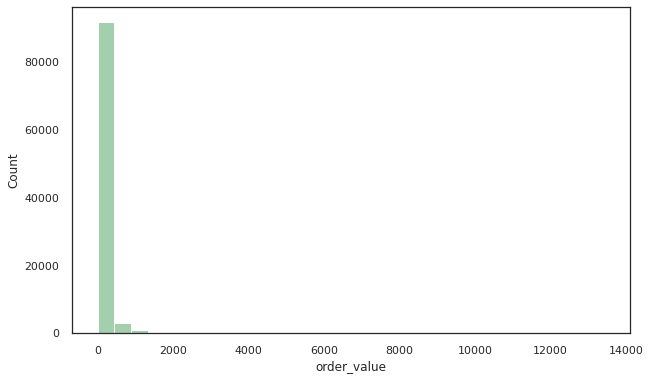

In [ ]:
sns.histplot(data=by_order,x='order_value',color='#86bf91', bins=30)
#sns.histplot(data=by_order,x='order_freight',color='#86bf91', bins=30)
#sns.histplot(data=by_order,x='order_item_ct',color='#86bf91', bins=30)

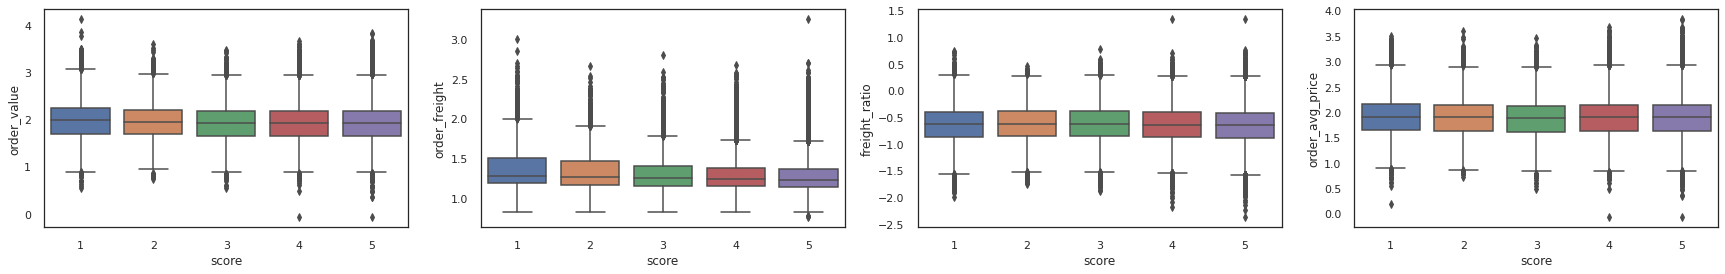

In [ ]:
#order value, freight, freight ratio, average price does not seem to affect ratings

fig, ((ax1, ax2,ax3, ax4)) = plt.subplots(1,4, figsize=(30,4))
sns.boxplot(x="score",y=np.log10(by_order.order_value),data=by_order,ax=ax1)
sns.boxplot(x="score",y=np.log10(by_order.order_freight),data=by_order, ax=ax2)

sns.boxplot(x="score",y=np.log10(by_order.freight_ratio),data=by_order, ax=ax3) #mostly value = 1 

sns.boxplot(x="score",y=np.log10(by_order.order_avg_price),data=by_order, ax=ax4)

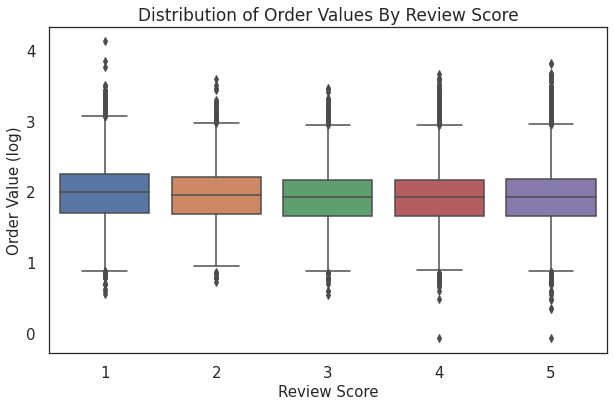

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x="score",y=np.log10(by_order.order_value),data=by_order)
ax.set_title('Distribution of Order Values By Review Score', fontsize=17)
ax.set_ylabel('Order Value (log)', fontsize=15)
ax.set_xlabel('Review Score', fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
plt.show()


sellers with more delivery delays have worse score

In [ ]:
by_seller = df.groupby('seller_id').agg(pos_review_pct=('review_sentiment','mean'),
                                 seller_order_ct=('order_id','count'),
                                 late_order_pct=('is_delay','mean')).reset_index()

by_seller['neg_review_pct'] = 1-by_seller['pos_review_pct']
by_seller['sale_volume'] = by_seller['seller_order_ct'].apply(lambda x: 'Low' if x <33 else 'High')
by_seller.head(10)

,seller_id,pos_review_pct,seller_order_ct,late_order_pct,neg_review_pct,sale_volume
0,0015a82c2db000af6aaaf3ae2ecb0532,0.666667,3,0.000000,0.333333,Low
1,001cca7ae9ae17fb1caed9dfb1094831,0.756477,193,0.062176,0.243523,High
2,002100f778ceb8431b7a1020ff7ab48f,0.703704,54,0.166667,0.296296,High
3,003554e2dce176b5555353e4f3555ac8,1.000000,1,0.000000,0.000000,Low
4,004c9cd9d87a3c30c522c48c4fc07416,0.762821,156,0.083333,0.237179,High
5,00720abe85ba0859807595bbf045a33b,0.600000,15,0.133333,0.400000,Low
6,00ab3eff1b5192e5f1a63bcecfee11c8,1.000000,1,0.000000,0.000000,Low
7,00d8b143d12632bad99c0ad66ad52825,1.000000,1,0.000000,0.000000,Low
8,00ee68308b45bc5e2660cd833c3f81cc,0.824818,137,0.087591,0.175182,High
9,00fc707aaaad2d31347cf883cd2dfe10,0.768519,108,0.046296,0.231481,High


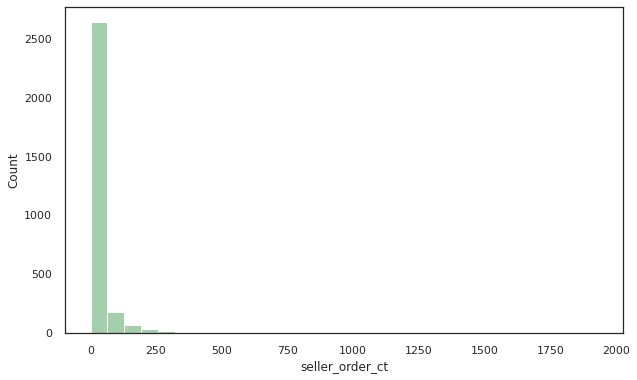

In [ ]:
sns.histplot(data=by_seller,x='seller_order_ct',color='#86bf91', bins=30)

In [ ]:
by_seller_plot = by_seller[(by_seller["neg_review_pct"] < 1) & (by_seller["late_order_pct"] < 1)]
by_seller_plot

,seller_id,pos_review_pct,seller_order_ct,late_order_pct,neg_review_pct,sale_volume
0,0015a82c2db000af6aaaf3ae2ecb0532,0.666667,3,0.000000,0.333333,Low
1,001cca7ae9ae17fb1caed9dfb1094831,0.756477,193,0.062176,0.243523,High
2,002100f778ceb8431b7a1020ff7ab48f,0.703704,54,0.166667,0.296296,High
3,003554e2dce176b5555353e4f3555ac8,1.000000,1,0.000000,0.000000,Low
4,004c9cd9d87a3c30c522c48c4fc07416,0.762821,156,0.083333,0.237179,High
...,...,...,...,...,...,...
2960,ffc470761de7d0232558ba5e786e57b7,0.785714,28,0.035714,0.214286,Low
2961,ffdd9f82b9a447f6f8d4b91554cc7dd3,0.833333,18,0.000000,0.166667,Low
2962,ffeee66ac5d5a62fe688b9d26f83f534,0.857143,14,0.142857,0.142857,Low
2963,fffd5413c0700ac820c7069d66d98c89,0.732143,56,0.125000,0.267857,High


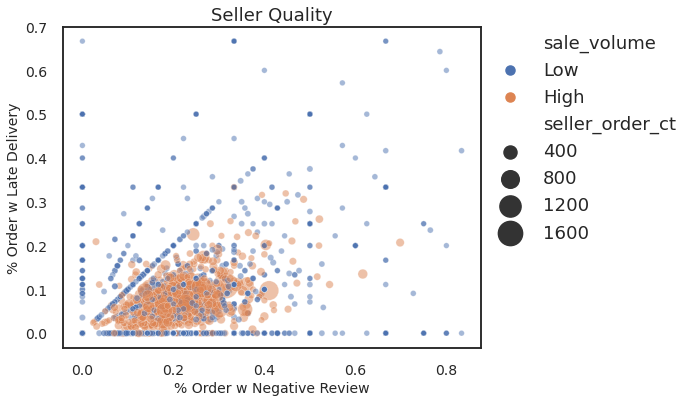

In [ ]:
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(10,6))
sns.scatterplot(x="neg_review_pct", 
                y="late_order_pct",
                size="seller_order_ct", 
                sizes=(30,700),
                alpha=0.5,
                hue= 'sale_volume',
                data=by_seller_plot)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

# Put the legend out of the figure
#plt.legend(bbox_to_anchor=(1.01, 0.54),  borderaxespad=0.)
plt.xlabel("% Order w Negative Review", fontsize=14)
plt.ylabel("% Order w Late Delivery", fontsize=14)
plt.title("Seller Quality", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

In [ ]:
#approval days by payment types


# Preparing the data for machine learning

Some features were retained for EDA purposes, but now need to be dropped in order to use machine learning models. This includes datetime features, features that are related to outcomes rather than related to the properties of the project itself categorical features which would result in too many one-hot encoded features. Due to lack of time, we are not looking at geolocation data yet.

In [ ]:
# list of non-predictive columns to remove from X
col_drops = ['order_id', 'product_id', 'seller_id', 'review_id', 'shipping_limit_date','qty',
             'price','freight_value', 'customer_id', 'order_status', 'order_purchase_timestamp',
             'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
             'order_estimated_delivery_date', 'customer_unique_id', 'customer_zip_code_prefix', 
             'customer_city', 'customer_state', 'product_category_name', 'product_category_name_eng',
             'seller_zip_code_prefix','seller_city', 'seller_state', 'message','payment_total',
             'score','days_variance','total_price','total_freight']

# 
df_model = df.drop(col_drops, axis=1)

### **Checking for distribution**

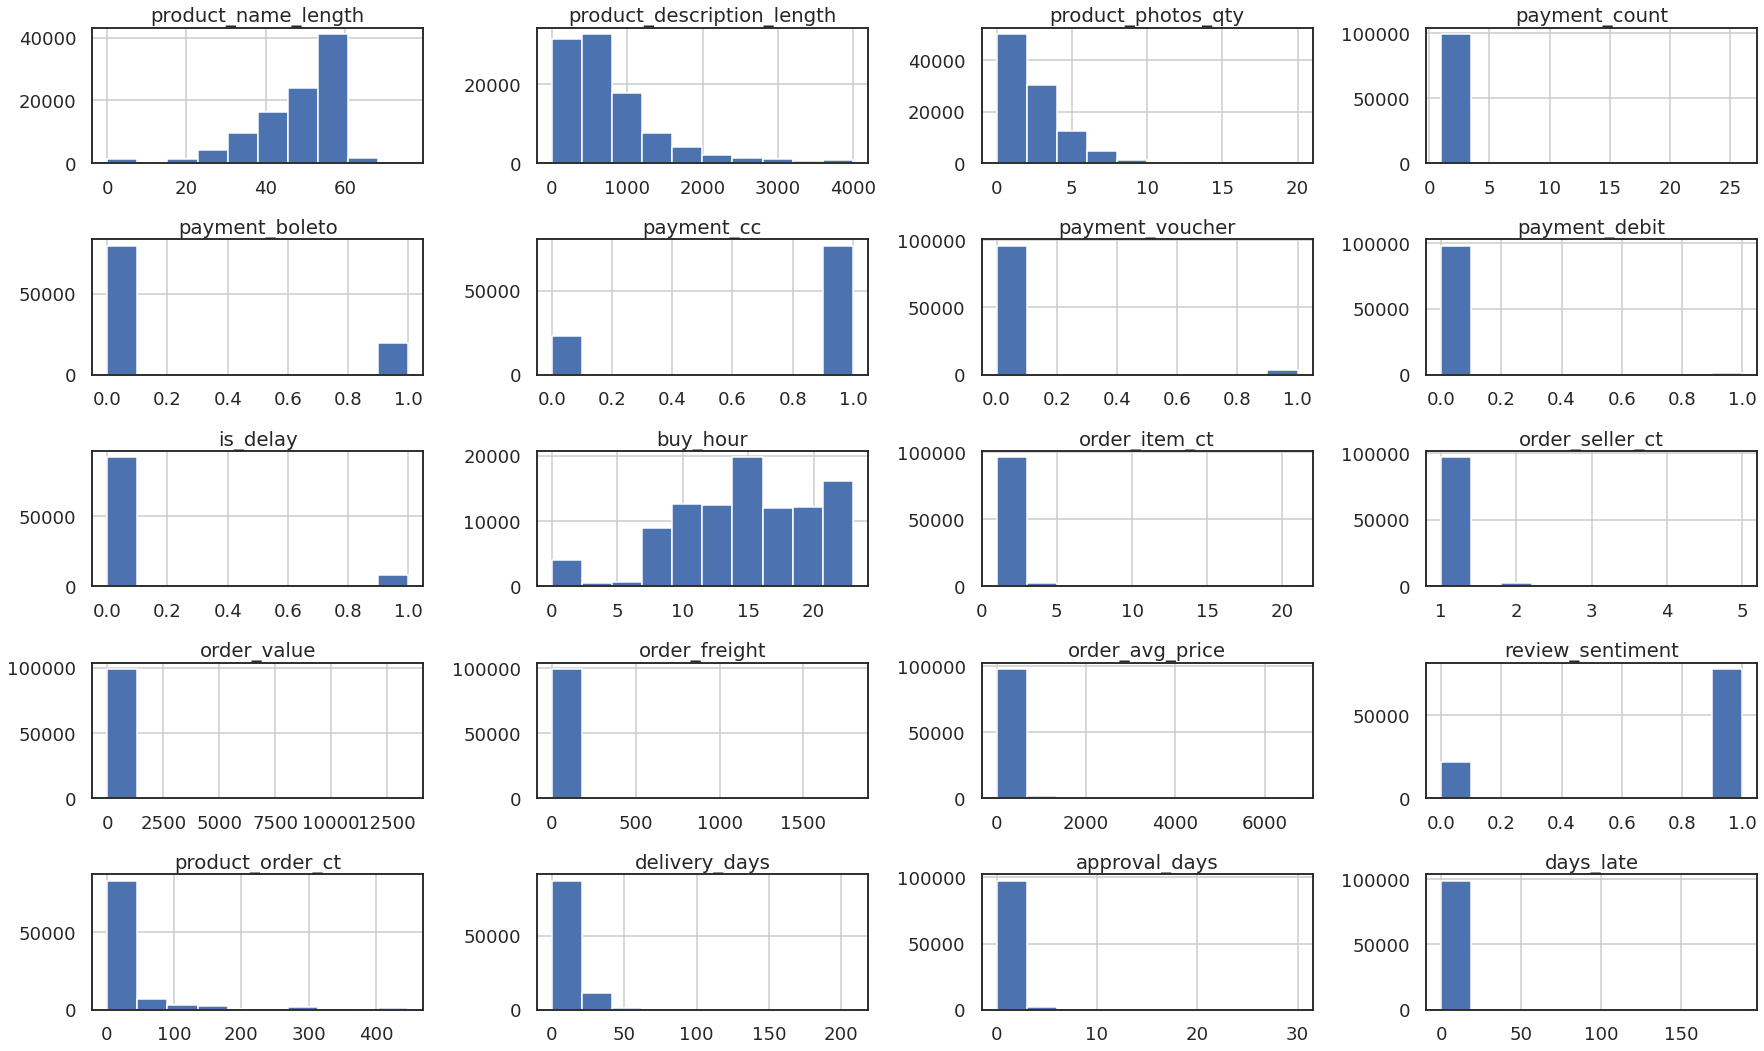

In [ ]:
# Checking the distributions of predictor features
df_model[df_model.describe().columns].hist(figsize=(25,15));
plt.tight_layout()
plt.show()


In [ ]:
df_model.product_order_ct.value_counts()

1     19047
2     10586
3      7020
4      5212
5      4365
      ...  
79       79
76       76
74       74
67       67
61       61
Name: product_order_ct, Length: 123, dtype: int64

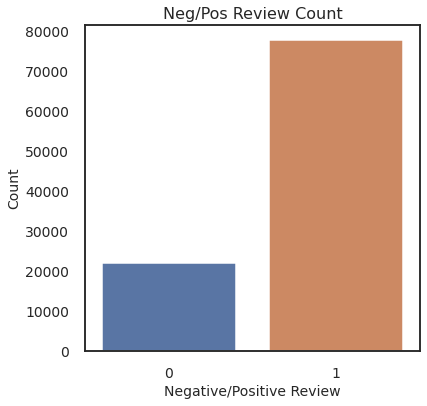

In [ ]:
plot_review = df_model.review_sentiment.value_counts().reset_index()
plot_review

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="index",y="review_sentiment",data=plot_review)

ax.set_title('Neg/Pos Review Count', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Negative/Positive Review', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

Most continuous numerical features are heavily positively skewed. This is not an issue for some machine learning models, so these features will not be log-transformed for the first few models. After that, models will be re-run using log-transformed data, to see whether this improves model accuracy.

## **Correlations**

Multi-collinearity will be checked for by assessing correlations between predictor features, as this can cause issues with some models. 

In [ ]:
#check non categorical variables:
df_model_corr = df_model.drop(columns=['review_sentiment', 'payment_boleto', 'payment_cc', 'payment_voucher', 'payment_debit','is_delay'], axis=1)


From the correlation matrix, we see that days_late is correlated with deliver_days (0.69), order_avg_price and order_value (0.92). We will drop days_late and order_avg_price and recalculate corr matrix

In [ ]:
df_model_corr2 = df_model_corr.drop(columns=['days_late','order_avg_price'])


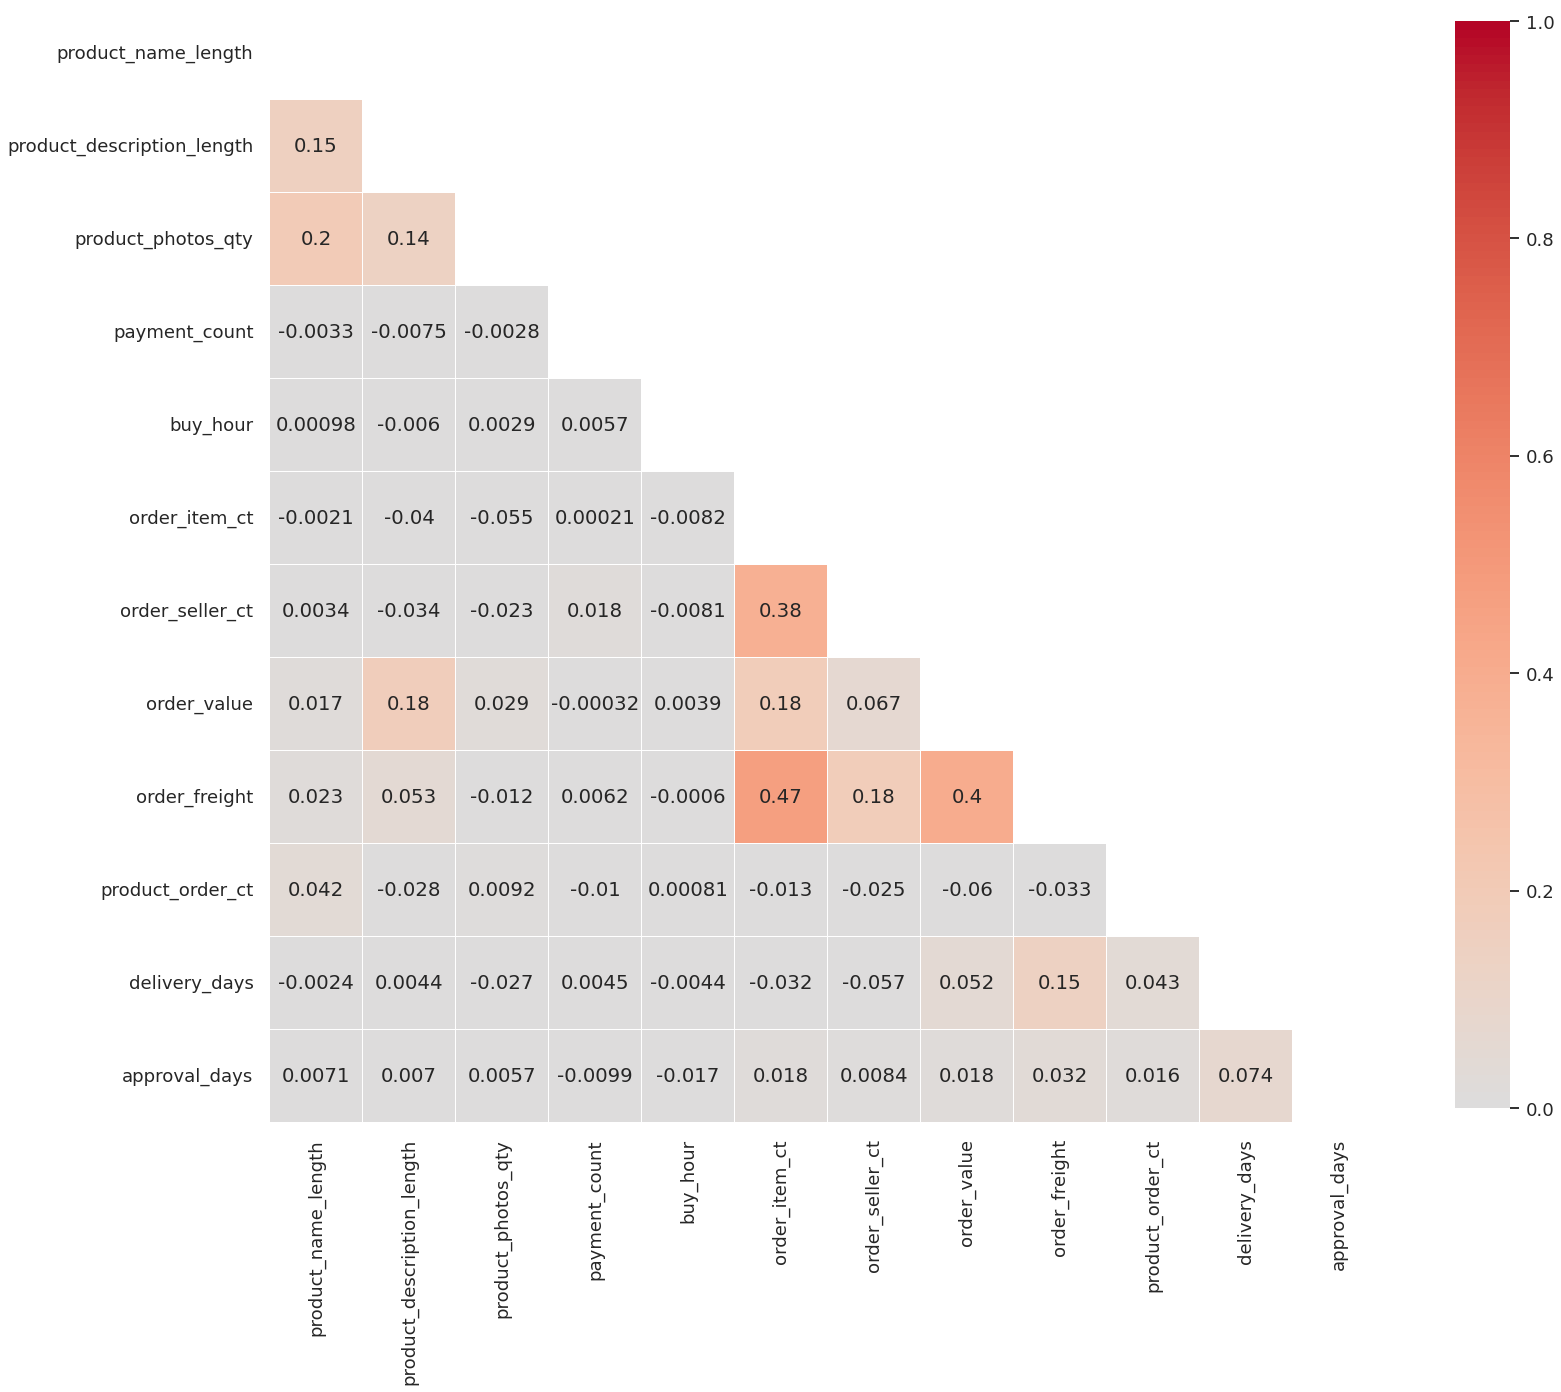

In [ ]:
#Create the collinearity matrix
corr = df_model_corr2.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True) #Color
mask = np.triu(np.ones_like(corr, dtype=bool)) #Masking the diagonoal and above
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(corr, center=0, cmap="coolwarm", square=True,
linewidth=0.3, cbar_kws={"shrink": .8}, annot=True, mask=mask, vmin=0, vmax=1)
#ax.set_title("Multi-Collinearity of the Olist dataset", fontsize=12)

sns.set(font_scale=1.5) 

The multi-collinearity matrix below shows that this is not an issue:

In [ ]:
#Drop'days_late','order_avg_price' in the  dataset:
df_model = df_model.drop(columns=['days_late','order_avg_price'])

## **Categorical features will now be one-hot encoded:**

In [ ]:
#day of week
day_of_week_dummies = pd.get_dummies(df_model['buy_day'], drop_first=False,dtype='int64')
#state_dummies = pd.get_dummies(df['customer_state'], drop_first=False, dtype='int64')
#state_dummies
df_model= pd.concat([df_model, day_of_week_dummies], axis=1)
len(df_model)

99479

In [ ]:
# assign bins to hour of day
df_model['Morning'] = df_model['buy_hour'].apply(lambda x: 1 if 6 <= x <= 11 else 0)
df_model['Afternoon'] = df_model['buy_hour'].apply(lambda x: 1 if 12 <= x <= 17 else 0)
df_model['Evening'] = df_model['buy_hour'].apply(lambda x: 1 if 18 <= x <= 23 else 0)
df_model['Overnight'] = df_model['buy_hour'].apply(lambda x: 1 if 0 <= x <= 5 else 0)

In [ ]:
df_payment = df.groupby(by=['review_sentiment'], as_index=False).agg(payment_boleto=('payment_boleto', 'sum'),
                                         payment_cc=('payment_cc', 'sum'),
                                         payment_voucher=('payment_voucher', 'sum'),
                                         payment_debit=('payment_debit', 'sum'))

In [ ]:
df_payment = df_payment.pivot_table(columns=['review_sentiment'])

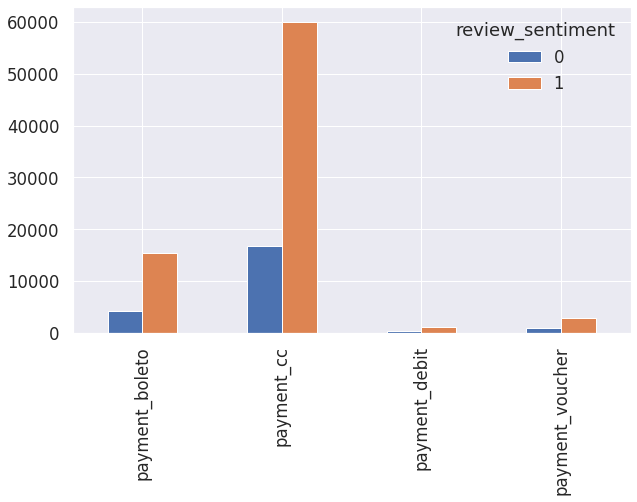

In [ ]:
df_payment.plot(kind='bar')
#28% boleto is 0
#28% cc is 0
#31% voucher is 0
#24% debit is 0

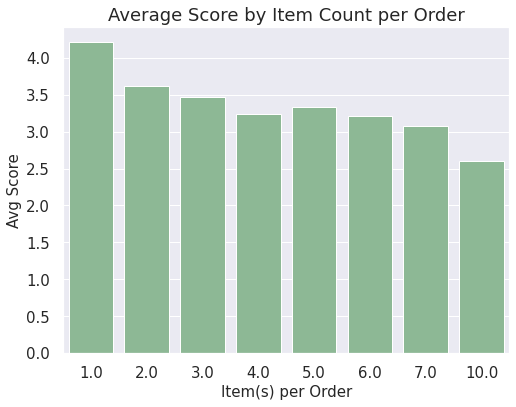

In [ ]:
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(x="order_item_ct", y="score", data=df_order_item_10, color = '#86bf91')

plt.xticks(rotation = 0)
plt.title('Average Score by Item Count per Order', fontsize=18)
plt.ylabel('Avg Score', fontsize=15)
plt.xlabel('Item(s) per Order', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
df_order_seller = df.groupby(by=['order_seller_ct'], as_index=False).agg(score=('score', 'mean'),
                                                                     orders =('order_id','count'))



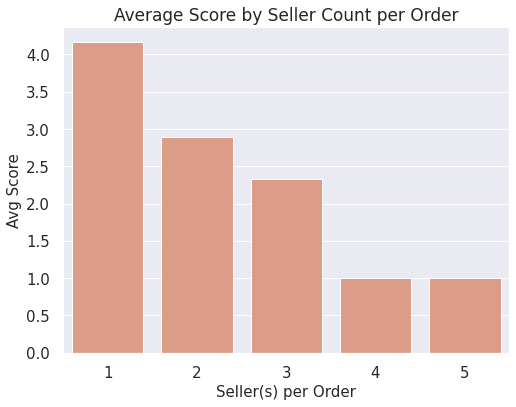

In [ ]:
sns.barplot(x="order_seller_ct", y="score", data=df_order_seller, color = 'darksalmon')

sns.set(rc={'figure.figsize':(6,6)})
plt.xticks(rotation = 0)
plt.title('Average Score by Seller Count per Order', fontsize=17)
plt.ylabel('Avg Score', fontsize=15)
plt.xlabel('Seller(s) per Order', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
df_model.head(1)

,product_name_length,product_description_length,product_photos_qty,payment_count,payment_boleto,payment_cc,payment_voucher,payment_debit,is_delay,buy_day,buy_hour,order_item_ct,order_seller_ct,order_value,order_freight,review_sentiment,product_order_ct,delivery_days,approval_days,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Morning,Afternoon,Evening,Overnight
0,58.0,598.0,4.0,1,0,1,0,0,0,Wednesday,8,1.0,1,58.9,13.29,1,9,7,0,0,0,0,0,0,0,1,1,0,0,0


## **Machine Learning**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

In [ ]:

df_model = df_model.drop(columns=['buy_day','buy_hour'], axis=1)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99479 entries, 0 to 99478
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_name_length         99479 non-null  float64
 1   product_description_length  99479 non-null  float64
 2   product_photos_qty          99479 non-null  float64
 3   payment_count               99479 non-null  int64  
 4   payment_boleto              99479 non-null  int64  
 5   payment_cc                  99479 non-null  int64  
 6   payment_voucher             99479 non-null  int64  
 7   payment_debit               99479 non-null  int64  
 8   is_delay                    99479 non-null  int64  
 9   order_item_ct               99479 non-null  float64
 10  order_seller_ct             99479 non-null  int64  
 11  order_value                 99479 non-null  float64
 12  order_freight               99479 non-null  float64
 13  review_sentiment            994

## **Standardize Data using StandardScaler()**

Finally, the dependent (y) and independent (X) features will be separated into separate datasets. Because the features are on different scales, independent features will be transformed and normalised using StandardScaler.

df_model is my clean data set to use for modeling. I will split it into train and test set, fit the scaler on your training data only, then standardise both training and test sets with that scaler. By fitting the scaler on the full dataset prior to splitting, information about the test set is used to transform the training set, which in turn is passed downstream.


In [ ]:
X_unscaled = df_model.drop('review_sentiment', axis=1)
y = df_model.review_sentiment

In [ ]:
y.value_counts()

1    77654
0    21825
Name: review_sentiment, dtype: int64

In [ ]:
SEED = 1911
jobs = -1
X_train, X_test, y_train, y_test = train_test_split(X_unscaled, y, test_size=0.20, stratify=y, random_state=SEED)

In [ ]:
# Transforming the data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)  

  
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)  


In [ ]:
X_test_scaled

,product_name_length,product_description_length,product_photos_qty,payment_count,payment_boleto,payment_cc,payment_voucher,payment_debit,is_delay,order_item_ct,order_seller_ct,order_value,order_freight,product_order_ct,delivery_days,approval_days,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Morning,Afternoon,Evening,Overnight
14345,0.330567,-0.427083,-0.120835,-0.119317,2.005720,-1.830102,-0.198299,-0.125344,-0.292292,-0.302146,-0.159537,-0.330508,-0.624480,-0.404999,0.000795,1.013248,2.449741,-0.440788,-0.348687,-0.371294,-0.416882,-0.437429,-0.430335,-0.537764,-0.790887,-0.722726,4.465130
61986,0.505236,-0.230234,-0.690932,-0.119317,-0.498574,0.546418,-0.198299,-0.125344,-0.292292,1.224369,-0.159537,-0.094868,0.556128,-0.449294,-0.210924,-0.363849,-0.408206,2.268662,-0.348687,-0.371294,-0.416882,-0.437429,-0.430335,-0.537764,1.264402,-0.722726,-0.223958
32404,0.767240,0.380306,0.449262,-0.119317,-0.498574,0.546418,-0.198299,-0.125344,-0.292292,-0.302146,-0.159537,0.847973,-0.579008,-0.434529,-0.846082,-0.363849,2.449741,-0.440788,-0.348687,-0.371294,-0.416882,-0.437429,-0.430335,-0.537764,-0.790887,1.383650,-0.223958
87906,-0.018771,-0.039536,-0.690932,-0.119317,-0.498574,0.546418,-0.198299,-0.125344,-0.292292,-0.302146,-0.159537,-0.005213,-0.332874,-0.419764,-0.528503,-0.363849,-0.408206,-0.440788,-0.348687,-0.371294,2.398761,-0.437429,-0.430335,-0.537764,1.264402,-0.722726,-0.223958
16299,-0.193440,-0.587023,-0.120835,-0.119317,2.005720,-1.830102,-0.198299,-0.125344,-0.292292,-0.302146,-0.159537,-0.533198,-0.383352,-0.419764,0.635954,1.013248,-0.408206,-0.440788,-0.348687,-0.371294,-0.416882,-0.437429,2.323773,-0.537764,1.264402,-0.722726,-0.223958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35542,-0.542778,-0.357878,-0.120835,-0.119317,-0.498574,0.546418,-0.198299,-0.125344,-0.292292,1.224369,-0.159537,0.074921,0.288301,-0.419764,0.106655,-0.363849,-0.408206,-0.440788,2.867904,-0.371294,-0.416882,-0.437429,-0.430335,-0.537764,1.264402,-0.722726,-0.223958
12628,-0.368109,0.197298,2.159553,-0.119317,-0.498574,0.546418,-0.198299,-0.125344,-0.292292,-0.302146,-0.159537,-0.330932,-0.470542,5.781442,-1.057802,-0.363849,-0.408206,-0.440788,-0.348687,-0.371294,-0.416882,-0.437429,2.323773,-0.537764,1.264402,-0.722726,-0.223958
12155,0.854574,1.865902,0.449262,-0.119317,-0.498574,0.546418,-0.198299,-0.125344,3.421231,-0.302146,-0.159537,0.164010,0.340448,-0.449294,1.800411,-0.363849,-0.408206,-0.440788,-0.348687,2.693285,-0.416882,-0.437429,-0.430335,-0.537764,1.264402,-0.722726,-0.223958
53313,0.068563,-0.351727,-0.690932,-0.119317,-0.498574,0.546418,-0.198299,-0.125344,3.421231,-0.302146,-0.159537,0.096368,0.090142,0.082238,4.235185,-0.363849,-0.408206,-0.440788,2.867904,-0.371294,-0.416882,-0.437429,-0.430335,-0.537764,1.264402,-0.722726,-0.223958


# **Modeling:**

In this section, machine learning models for classification will be applied to the data, in order to create a model to classify projects into positives and negatives.


We will create a logistic regression model to classify projects into successes and failures. We will try it with original data and again with log-transformed data, to see which one is better

It is good practice to choose an evaluation method before running machine learning models - not after. The weighted average F1 score was chosen. The F1 score calculates the harmonic mean between precision and recall, and is a suitable measure because there is no preference for false positives (predict success but actually not) or false negatives (predict failure but actually not) in this case (both are equally bad). The weighted average will be used because the classes are of slightly different sizes, and we want to be able to predict both successes and failures.

We will split our data into a test and train sets, then start building our Logistic Regression model. We will use a 80/20 split.

## **Model 1: logistic regression**

In [ ]:
# Fitting a logistic regression model with default parameters
logreg = LogisticRegression(random_state=SEED, n_jobs=jobs)

In [ ]:
logreg.fit(X_train_scaled,y_train)
# Making predictions
lr_y_hat_train = logreg.predict(X_train_scaled)
lr_y_hat_test = logreg.predict(X_test_scaled)

In [ ]:
# Logistic regression scores
print("Logistic regression score for training set:", round(logreg.score(X_train_scaled, y_train),5))
print("Logistic regression score for test set:", round(logreg.score(X_test_scaled, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, lr_y_hat_test))

Logistic regression score for training set: 0.81329
Logistic regression score for test set: 0.81087

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.28      0.39      4365
           1       0.83      0.96      0.89     15531

    accuracy                           0.81     19896
   macro avg       0.75      0.62      0.64     19896
weighted avg       0.79      0.81      0.78     19896



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, lr_y_hat_test)
cm

array([[ 1216,  3149],
       [  614, 14917]])

In [ ]:
import itertools
def plot_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    plt.grid(b=None)
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

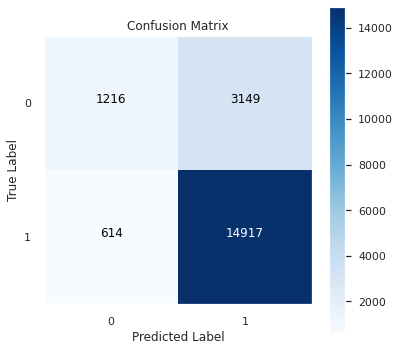

In [ ]:
# Confusion matrix
plot_cf(y_test, lr_y_hat_test)

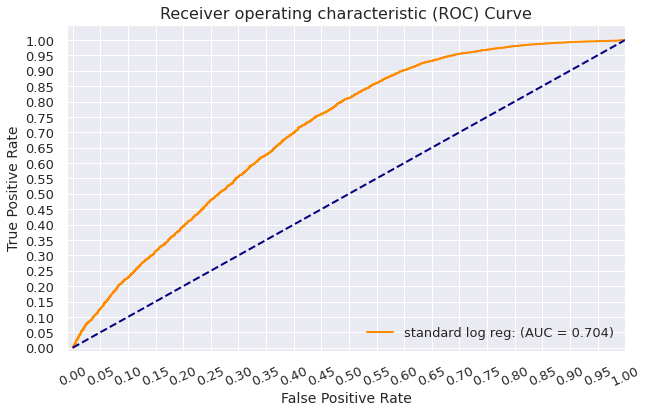

In [ ]:
from sklearn import metrics
lr_y_hat_proba = logreg.predict_proba(X_test_scaled)[::,1]
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test,  lr_y_hat_proba)
lr_auc = metrics.roc_auc_score(y_test, lr_y_hat_proba)

#create ROC curve

from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(10,6))
lw = 2
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.plot(lr_fpr, lr_tpr, label='standard log reg: (AUC = %0.3f)' % lr_auc, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.yticks([i/20.0 for i in range(21)], fontsize=13)
plt.xticks([i/20.0 for i in range(21)], fontsize=13, rotation = 25)
plt.title('Receiver operating characteristic (ROC) Curve',fontsize=16)
plt.legend(loc=4, fontsize=13)

#from matplotlib.ticker import FormatStrFormatter
#fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

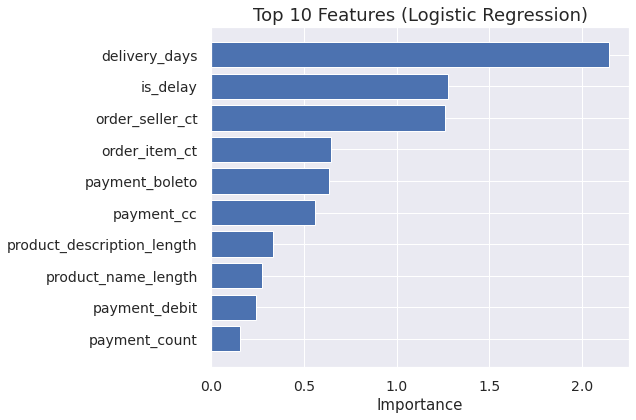

In [ ]:
lr_feature_importance = abs(logreg.coef_[0])
lr_feature_importance = 100.0 * (lr_feature_importance / lr_feature_importance.max())
sorted_idx = np.argsort(lr_feature_importance)
sorted_idx_10 = sorted_idx[:10]
#pos = np.arange(sorted_idx.shape[0]) + .5
pos_10 = np.arange(sorted_idx_10.shape[0]) + .05
lr_feature_importance_10=lr_feature_importance[sorted_idx][:10]


featfig = plt.figure(figsize=(9,6))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos_10, lr_feature_importance_10, align='center')
featax.set_yticks(pos_10)
featax.set_yticklabels(np.array(X_unscaled.columns)[sorted_idx][-10:], fontsize=12)
featax.tick_params(axis='both', which='major', labelsize=14)
featax.set_xlabel('Relative Feature Importance',fontsize=15)
featax.set_xlabel('Importance',fontsize=15)
featax.set_title('Top 10 Features (Logistic Regression)',fontsize=18)

plt.tight_layout()   
plt.show()


In [ ]:
np.array(X_unscaled.columns)

array(['product_name_length', 'product_description_length',
       'product_photos_qty', 'payment_count', 'payment_boleto',
       'payment_cc', 'payment_voucher', 'payment_debit', 'is_delay',
       'order_item_ct', 'order_seller_ct', 'order_value', 'order_freight',
       'product_order_ct', 'delivery_days', 'approval_days', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'Morning', 'Afternoon', 'Evening', 'Overnight'], dtype=object)

### **Model 2: Random Forest Classifier**

In [ ]:
rf = RandomForestClassifier(random_state=SEED).fit(X_train_scaled, y_train)

In [ ]:
# Random Forest scores
rf_y_hat_train = rf.predict(X_train_scaled)
rf_y_hat_test = rf.predict(X_test_scaled)
print("Random Forest score for training set:", round(rf.score(X_train_scaled, y_train),5))
print("Random Forest score for test set:", round(rf.score(X_test_scaled, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, rf_y_hat_test))
plot_cf(y_test, rf_y_hat_test)

NameError: ignored

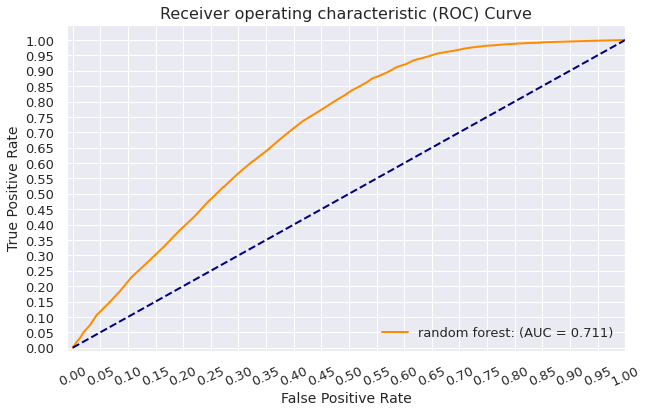

In [ ]:
from sklearn import metrics
rf_y_hat_proba = rf.predict_proba(X_test_scaled)[::,1]
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test,  rf_y_hat_proba)
rf_auc = metrics.roc_auc_score(y_test, rf_y_hat_proba)

#create ROC curve

from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(10,6))
lw = 2
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.plot(rf_fpr, rf_tpr, label = 'random forest: (AUC = %0.3f)' % rf_auc, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.yticks([i/20.0 for i in range(21)], fontsize=13)
plt.xticks([i/20.0 for i in range(21)], fontsize=13, rotation = 25)
plt.title('Receiver operating characteristic (ROC) Curve',fontsize=16)
plt.legend(loc=4, fontsize=13)

#from matplotlib.ticker import FormatStrFormatter
#fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

In [ ]:
input_features = np.array(X_train_scaled.columns)
features_imp_rf = pd.DataFrame({'feature_name': input_features, 'feature_importance': rf.feature_importances_})
features_imp_rf = features_imp_rf.sort_values(by='feature_importance', ascending=False)

In [ ]:
features_imp_rf_10 = features_imp_rf.head(10)

#### Plotting **Feature Importance** obtained from Random Forest Classifier.

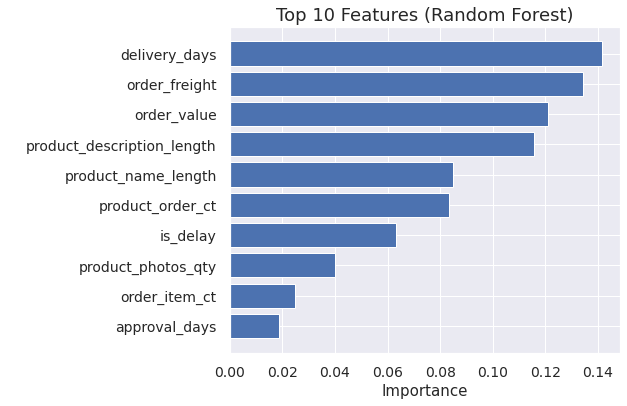

In [ ]:

plt.figure(figsize=(7,6))
plt.barh(y=features_imp_rf_10['feature_name'], width=features_imp_rf_10['feature_importance'])
plt.xlabel("Importance",fontsize=15)
plt.ylabel(" ",fontsize=15)
plt.title("Top 10 Features (Random Forest)",fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.gca().invert_yaxis()

#featax.set_yticklabels(np.array(X_unscaled.columns)[sorted_idx][-20:], fontsize=12)

# **Model 3: Logistic Regression, with Log Transformation**
Previously, positively skewed data was not log-transformed. Now a log transformation will be applied to the skewed features, and a logistic regression model fitted again to see whether this improved accuracy.

In [ ]:
df_transformed = df_model.copy()

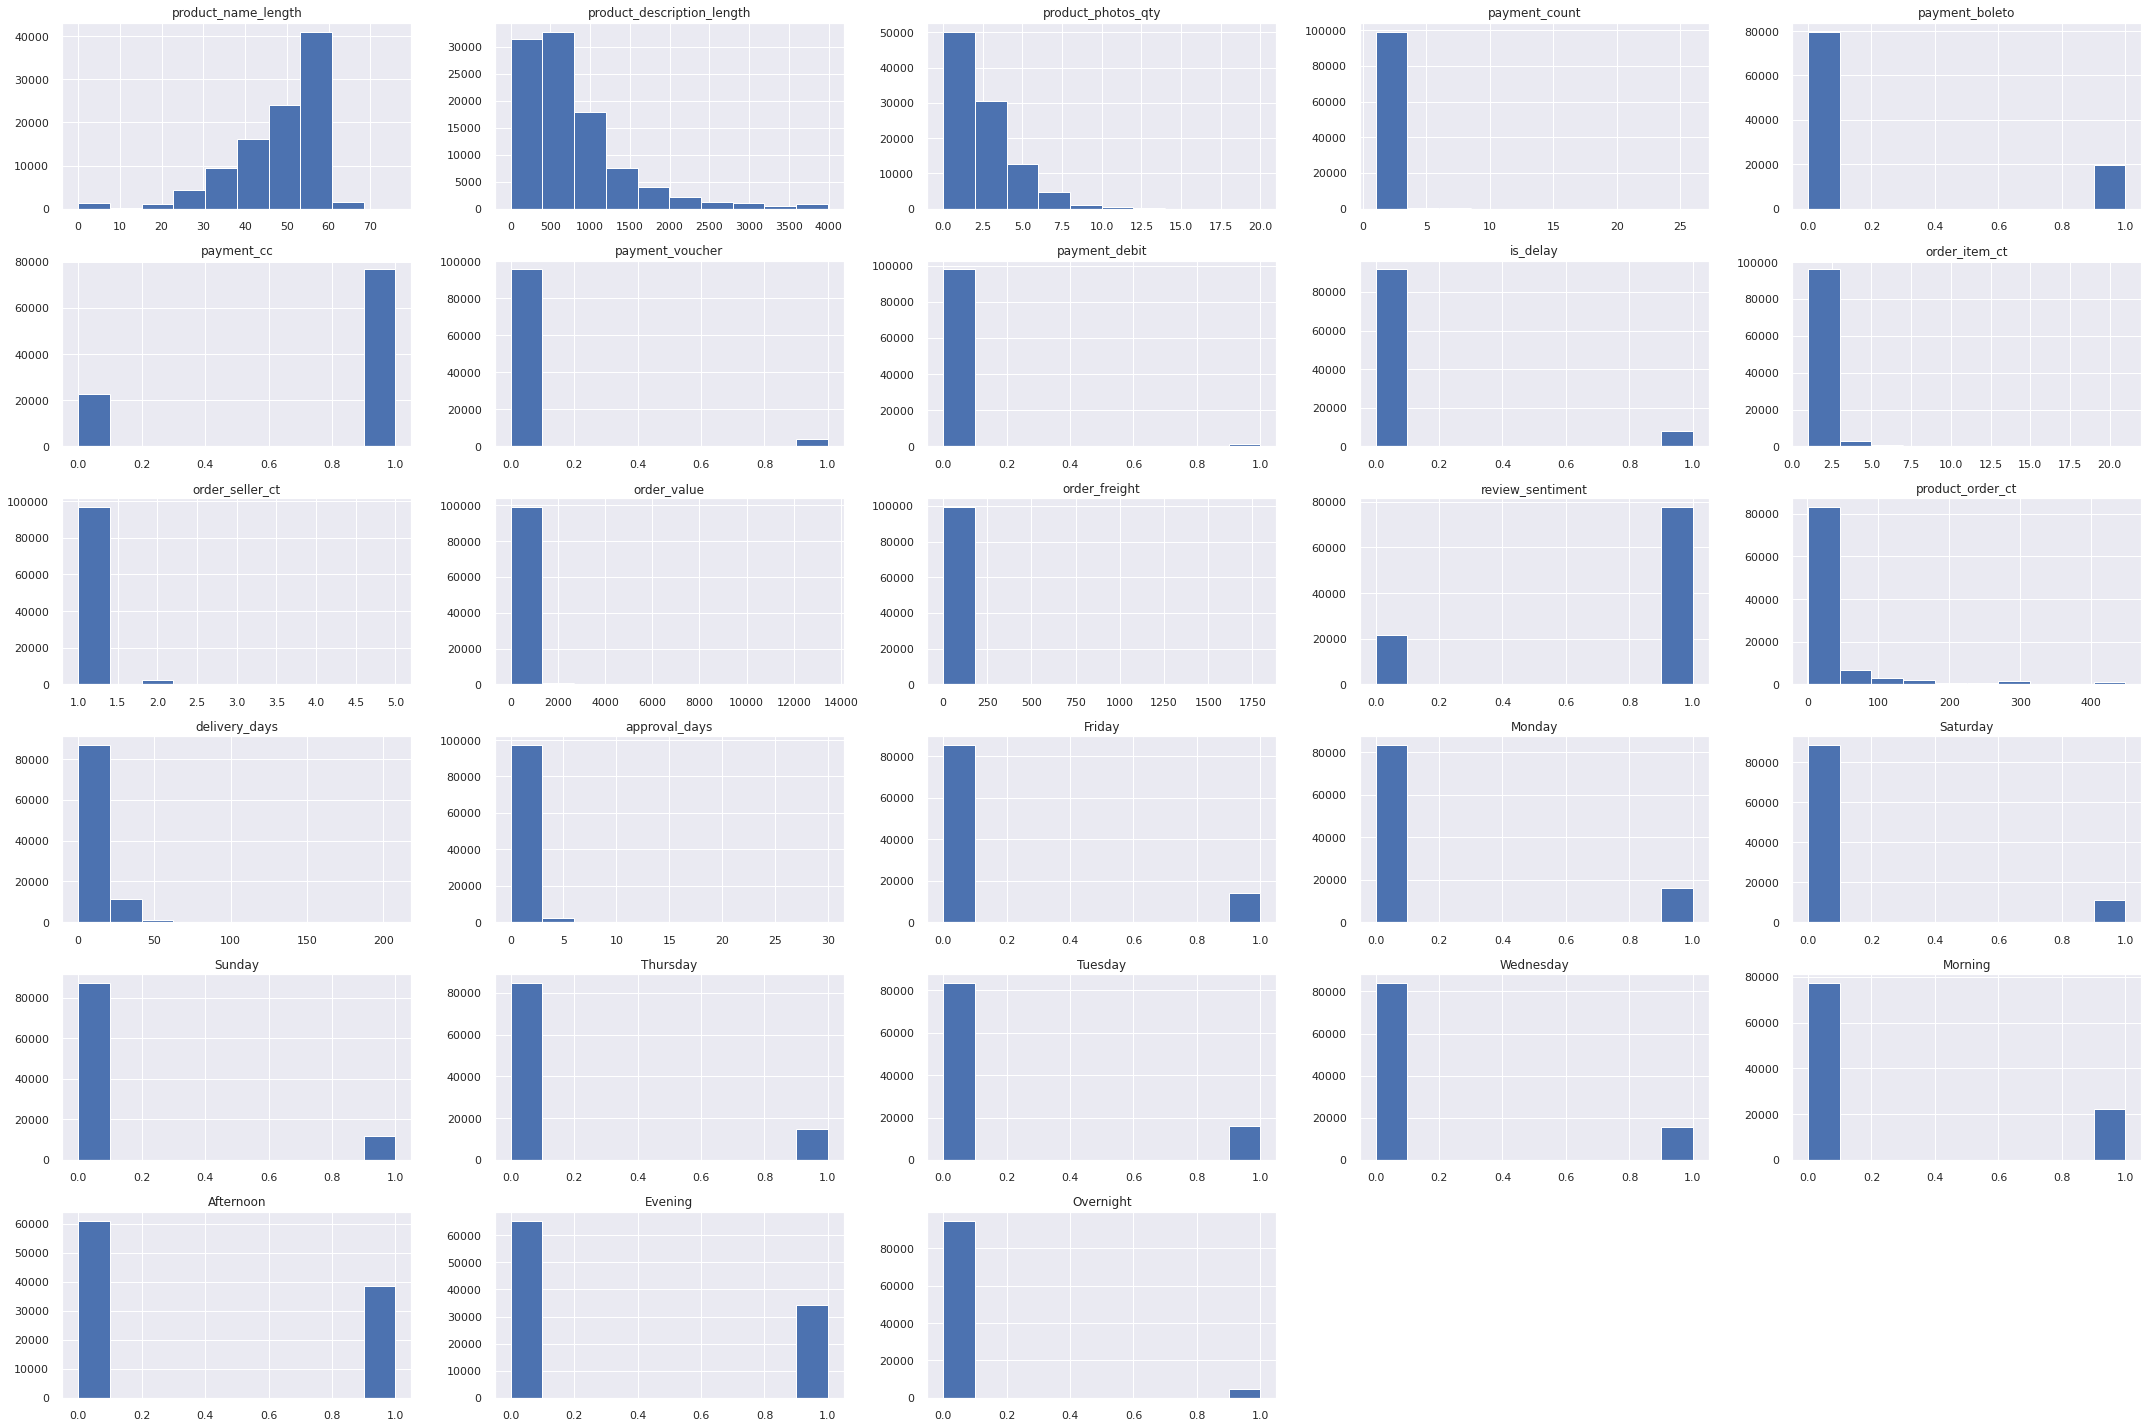

In [ ]:
# Assessing skewed distributions

df_transformed[df_transformed.describe().columns].hist(figsize=(30,20))
plt.tight_layout()
plt.show()

In [ ]:
cols_to_log = ['product_description_length','product_photos_qty','payment_count','order_item_ct',
          'order_seller_ct','order_value','order_freight',
          'product_order_ct','delivery_days','approval_days']

In [ ]:
# Replacing 0s with 0.01 and log-transforming
for col in cols_to_log:
    df_transformed[col] = df_transformed[col].astype('float64').replace(0.0, 0.01)
    df_transformed[col] = np.log(df_transformed[col])

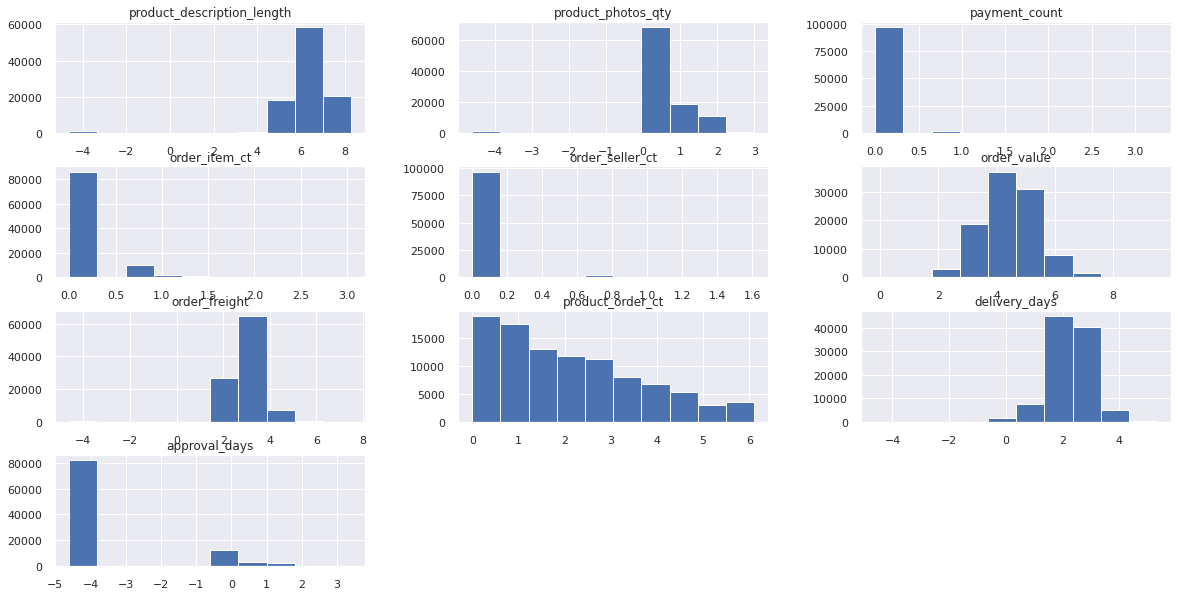

In [ ]:
# Checking new distributions
df_transformed[cols_to_log].hist(figsize=(20,10));


In [ ]:
dict = {'product_description_length': 'product_description_length_log',
        'product_photos_qty': 'product_photos_qty_log',
        'payment_count': 'payment_count_log',
        'order_item_ct':'order_item_ct_log',
        'order_seller_ct':'order_seller_ct_log',
        'order_value':'order_value_log',
        'order_freight':'order_freight_log',
        'product_order_ct':'product_order_ct_log',
        'delivery_days':'delivery_days_log',
        'approval_days':'approval_days_log'}
  
# call rename () method
df_transformed.rename(columns=dict,
          inplace=True)
  
# print Data frame after rename columns
display(df_transformed)

,product_name_length,product_description_length_log,product_photos_qty_log,payment_count_log,payment_boleto,payment_cc,payment_voucher,payment_debit,is_delay,order_item_ct_log,order_seller_ct_log,order_value_log,order_freight_log,review_sentiment,product_order_ct_log,delivery_days_log,approval_days_log,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Morning,Afternoon,Evening,Overnight
0,58.0,6.393591,1.386294,0.0,0,1,0,0,0,0.000000,0.0,4.075841,2.587012,1,2.197225,1.945910,-4.60517,0,0,0,0,0,0,1,1,0,0,0
1,58.0,6.393591,1.386294,0.0,1,0,0,0,0,0.000000,0.0,4.023564,2.888147,1,2.197225,2.708050,-4.60517,0,0,0,0,0,0,1,1,0,0,0
2,58.0,6.393591,1.386294,0.0,0,1,0,0,0,0.000000,0.0,4.172848,2.908539,1,2.197225,2.833213,-4.60517,1,0,0,0,0,0,0,1,0,0,0
3,58.0,6.393591,1.386294,0.0,0,1,0,0,0,0.000000,0.0,4.075841,2.783158,1,2.197225,2.079442,-4.60517,0,0,0,0,0,1,0,0,0,1,0
4,58.0,6.393591,1.386294,0.0,0,1,0,0,0,0.000000,0.0,4.075841,2.587012,1,2.197225,2.564949,-4.60517,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99474,49.0,6.267201,1.386294,0.0,0,1,0,0,0,0.000000,0.0,4.317488,3.313458,0,0.000000,2.197225,-4.60517,0,1,0,0,0,0,0,0,1,0,0
99475,38.0,7.172425,0.693147,0.0,1,0,0,0,1,0.693147,0.0,5.837089,3.655840,1,0.000000,3.044522,-4.60517,0,0,0,0,1,0,0,1,0,0,0
99476,44.0,6.278521,0.693147,0.0,1,0,0,0,1,0.000000,0.0,4.786658,2.781301,1,0.000000,3.555348,0.00000,0,0,0,0,0,0,1,1,0,0,0
99477,32.0,7.174724,1.098612,0.0,1,0,0,0,0,0.000000,0.0,5.342334,2.785628,1,0.000000,1.791759,-4.60517,1,0,0,0,0,0,0,1,0,0,0


In [ ]:
#square transformation left skewed var

df_transformed['product_name_length']=np.power((df_transformed['product_name_length']),2)
df_transformed.rename(columns={'product_name_length': 'product_name_length_sq'},
          inplace=True)


Now the data can be prepared again for machine learning by separating X and y, and scaling:

In [ ]:
X_unscaled_log = df_transformed.drop('review_sentiment', axis=1)
y_log = df_transformed.review_sentiment

In [ ]:
SEED = 5110
X_train, X_test, y_train, y_test = train_test_split(X_unscaled_log, y_log, test_size=0.2, random_state=SEED)

In [ ]:
# Transforming the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)  

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)  


Logistic regression score for training set: 0.81281
Logistic regression score for test set: 0.8082

Classification report:
              precision    recall  f1-score   support

           0       0.63      0.28      0.39      4331
           1       0.83      0.95      0.89     15565

    accuracy                           0.81     19896
   macro avg       0.73      0.62      0.64     19896
weighted avg       0.78      0.81      0.78     19896



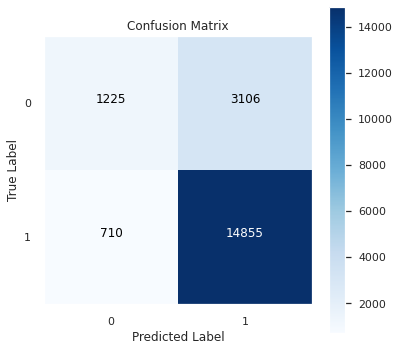

In [ ]:
# Fitting a logistic regression model with default parameters
logreg_log = LogisticRegression(random_state=SEED)
logreg_log.fit(X_train_scaled,y_train)

# Making predictions
lr_log_y_hat_train2 = logreg_log.predict(X_train_scaled)
lr_log_y_hat_test2 = logreg_log.predict(X_test_scaled)

# Logistic regression scores
print("Logistic regression score for training set:", round(logreg_log.score(X_train_scaled, y_train),5))
print("Logistic regression score for test set:", round(logreg_log.score(X_test_scaled, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, lr_log_y_hat_test2))
# Confusion matrix
plot_cf(y_test, lr_log_y_hat_test2)

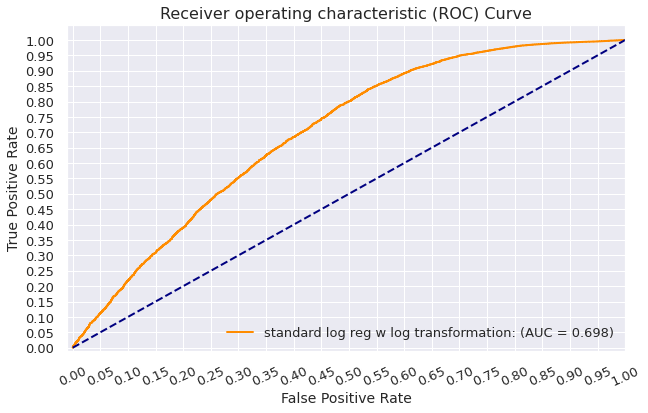

In [ ]:
from sklearn import metrics
lr_log_y_hat_proba = logreg_log.predict_proba(X_test_scaled)[::,1]
lr_log_fpr, lr_log_tpr, _ = metrics.roc_curve(y_test,  lr_log_y_hat_proba)
lr_log_auc = metrics.roc_auc_score(y_test, lr_log_y_hat_proba)

#create ROC curve

from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(10,6))
lw = 2
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.plot(lr_log_fpr, lr_log_tpr, label='standard log reg w log transformation: (AUC = %0.3f)' % lr_log_auc, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.yticks([i/20.0 for i in range(21)], fontsize=13)
plt.xticks([i/20.0 for i in range(21)], fontsize=13, rotation = 25)
plt.title('Receiver operating characteristic (ROC) Curve',fontsize=16)
plt.legend(loc=4, fontsize=13)

#from matplotlib.ticker import FormatStrFormatter
#fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

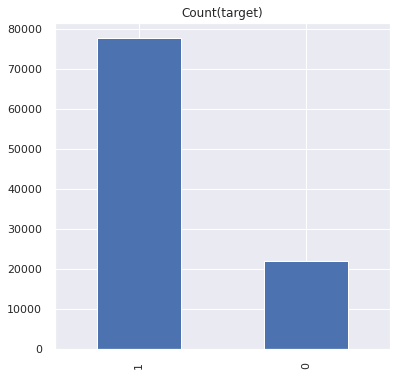

In [ ]:
df_model.review_sentiment.value_counts().plot(kind='bar', title='Count(target)')

In [ ]:
# Split the main dataset df_model into train and test set. We will do resampling on the train set.
train, test = train_test_split(df_model, test_size=0.2)
train_ct_pos, train_ct_neg = train.review_sentiment.value_counts()

#count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
#df_class_0 = df_train[df_train['target'] == 0]
#df_class_1 = df_train[df_train['target'] == 1]

df_neg = train[train['review_sentiment'] == 0]
df_pos = train[train['review_sentiment'] == 1]

# **Oversampling**


In [ ]:
from sklearn.utils import resample

In [ ]:
df_neg_over = resample(df_neg, n_samples=train_ct_pos)
df_pos = df_pos

df_train_over = pd.concat((df_pos, df_neg_over))
#balanced_df is the resampled training data
#test is the testing data

In [ ]:
df_train_over['review_sentiment'].value_counts()

1    62055
0    62055
Name: review_sentiment, dtype: int64

In [ ]:
X_train_over = df_train_over.drop('review_sentiment', axis=1)
y_train_over = df_train_over.review_sentiment

In [ ]:
X_test_over = test.drop('review_sentiment', axis=1)
y_test_over = test.review_sentiment

In [ ]:
# Transforming the data
scaler = StandardScaler()
X_train_over_scaled = scaler.fit_transform(X_train_over)
X_train_over_scaled = pd.DataFrame(X_train_over_scaled, columns=X_train_over.columns, index=X_train_over.index)  

X_test_over_scaled = scaler.transform(X_test_over)
X_test_over_scaled = pd.DataFrame(X_test_over_scaled, columns=X_test_over.columns, index=X_test_over.index)  


# **Model 4: Logistic Regression on the Oversampled Data**

Logistic regression Oversampled score for training set: 0.65986
Logistic regression Oversampled score for test set: 0.7594

Classification report:
              precision    recall  f1-score   support

           0       0.45      0.49      0.47      4297
           1       0.86      0.83      0.84     15599

    accuracy                           0.76     19896
   macro avg       0.65      0.66      0.66     19896
weighted avg       0.77      0.76      0.76     19896



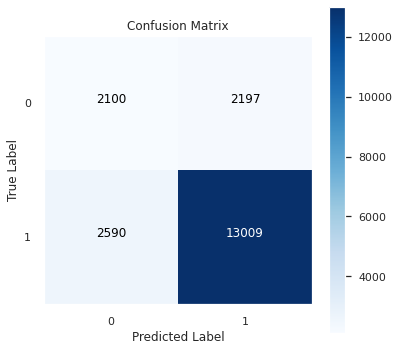

In [ ]:
# Fitting a logistic regression model with default parameters
logreg_os = LogisticRegression(random_state=SEED)
logreg_os.fit(X_train_over_scaled,y_train_over)

# Making predictions
y_hat_train_over = logreg_os.predict(X_train_over_scaled)
y_hat_test_over = logreg_os.predict(X_test_over_scaled)

# Logistic regression scores
print("Logistic regression Oversampled score for training set:", round(logreg_os.score(X_train_over_scaled, y_train_over),5))
print("Logistic regression Oversampled score for test set:", round(logreg_os.score(X_test_over_scaled, y_test_over),5))
print("\nClassification report:")
print(classification_report(y_test_over, y_hat_test_over))
# Confusion matrix
plot_cf(y_test_over, y_hat_test_over)

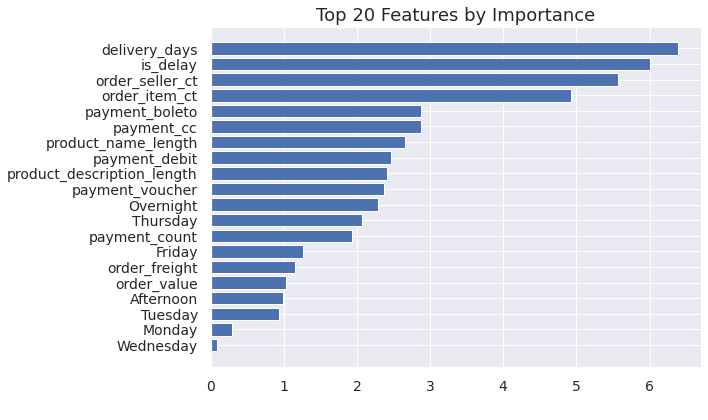

In [ ]:
lr_os_feature_importance = abs(logreg_os.coef_[0])
lr_os_feature_importance = 100.0 * (lr_os_feature_importance / lr_os_feature_importance.max())
sorted_idx = np.argsort(lr_os_feature_importance)
sorted_idx_20 = sorted_idx[:20]
#pos = np.arange(sorted_idx.shape[0]) + .5
pos_20 = np.arange(sorted_idx_20.shape[0]) + .05
lr_os_feature_importance_20=lr_os_feature_importance[sorted_idx][:20]


featfig = plt.figure(figsize=(10,6))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos_20, lr_os_feature_importance_20, align='center')
featax.set_yticks(pos_20)
featax.set_yticklabels(np.array(X_unscaled.columns)[sorted_idx][-20:], fontsize=12)
featax.tick_params(axis='both', which='major', labelsize=14)
featax.set_xlabel('Relative Feature Importance',fontsize=15)
featax.set_xlabel(' ',fontsize=15)
featax.set_title('Top 20 Features by Importance',fontsize=18)

plt.tight_layout()   
plt.show()

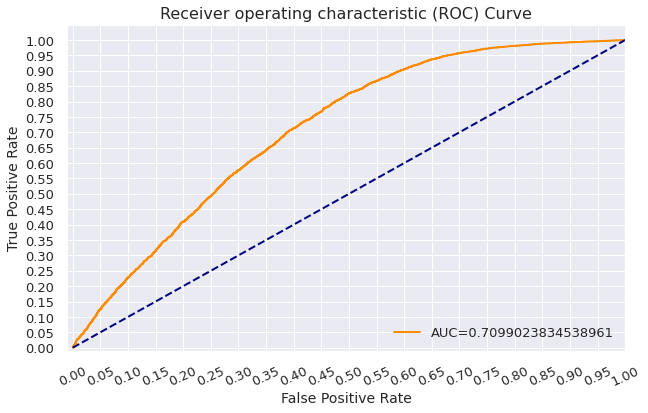

In [ ]:
from sklearn import metrics
lr_os_y_hat_proba = logreg_os.predict_proba(X_test_over_scaled)[::,1]
lr_os_fpr, lr_os_tpr, _ = metrics.roc_curve(y_test_over,  lr_os_y_hat_proba)
lr_os_auc = metrics.roc_auc_score(y_test_over, lr_os_y_hat_proba)


#create ROC curve

from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(10,6))
lw = 2
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.plot(lr_os_fpr,lr_os_tpr, label="AUC="+str(lr_os_auc), color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.yticks([i/20.0 for i in range(21)], fontsize=13)
plt.xticks([i/20.0 for i in range(21)], fontsize=13, rotation = 25)
plt.title('Receiver operating characteristic (ROC) Curve',fontsize=16)
plt.legend(loc=4, fontsize=13)

#from matplotlib.ticker import FormatStrFormatter
#fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

# **Model 5: Random Forest on the Oversampled Data**

RF Oversampled score for training set: 0.99961
RF Oversampled score for test set: 0.82333

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47      4297
           1       0.84      0.95      0.89     15599

    accuracy                           0.82     19896
   macro avg       0.76      0.66      0.68     19896
weighted avg       0.81      0.82      0.80     19896



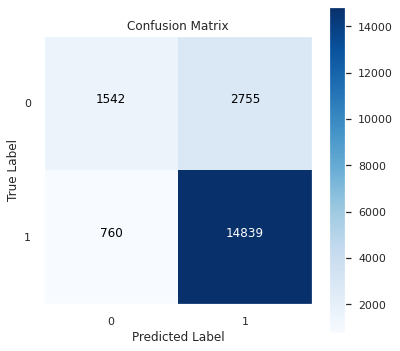

In [ ]:
# Random Forest scores
rf_os= RandomForestClassifier(random_state=SEED).fit(X_train_over_scaled, y_train_over)
y_hat_train2_over = rf_os.predict(X_train_over_scaled)
y_hat_test2_over = rf_os.predict(X_test_over_scaled)
print("RF Oversampled score for training set:", round(rf_os.score(X_train_over_scaled, y_train_over),5))
print("RF Oversampled score for test set:", round(rf_os.score(X_test_over_scaled, y_test_over),5))
print("\nClassification report:")
print(classification_report(y_test_over, y_hat_test2_over))
plot_cf(y_test_over, y_hat_test2_over)

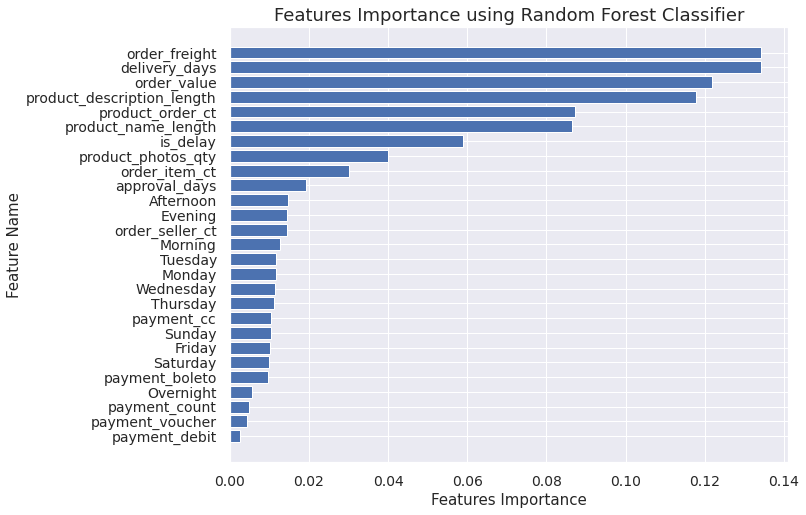

In [ ]:
input_features = np.array(X_train_over_scaled.columns)
features_imp_rf = pd.DataFrame({'feature_name': input_features, 'feature_importance': rf_os.feature_importances_})
features_imp_rf = features_imp_rf.sort_values(by='feature_importance', ascending=True)

plt.figure(figsize=(10,8))
plt.barh(y=features_imp_rf['feature_name'], width=features_imp_rf['feature_importance'])
plt.xlabel("Features Importance",fontsize=15)
plt.ylabel("Feature Name",fontsize=15)
plt.title("Features Importance using Random Forest Classifier",fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)

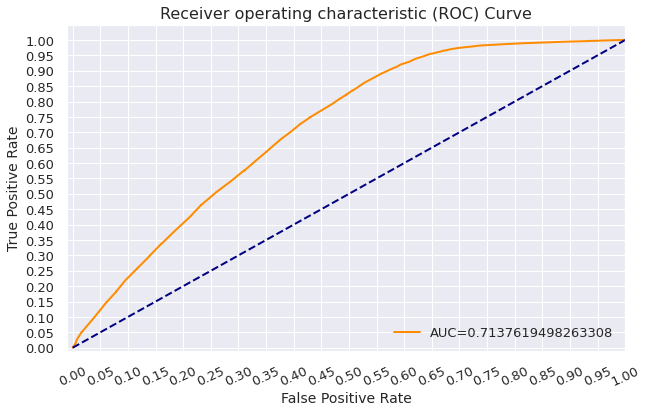

In [ ]:
from sklearn import metrics
rf_os_y_hat_proba = rf_os.predict_proba(X_test_over_scaled)[::,1]
rf_os_fpr, rf_os_tpr, _ = metrics.roc_curve(y_test_over,  rf_os_y_hat_proba)
rf_os_auc = metrics.roc_auc_score(y_test_over, rf_os_y_hat_proba)

#create ROC curve

from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(10,6))
lw = 2
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.plot(rf_os_fpr,rf_os_tpr, label="AUC="+str(rf_os_auc), color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.yticks([i/20.0 for i in range(21)], fontsize=13)
plt.xticks([i/20.0 for i in range(21)], fontsize=13, rotation = 25)
plt.title('Receiver operating characteristic (ROC) Curve',fontsize=16)
plt.legend(loc=4, fontsize=13)

#from matplotlib.ticker import FormatStrFormatter
#fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

# **Undersampling**

In [ ]:
df_pos_under = resample(df_pos, n_samples=train_ct_neg)
df_neg = df_neg

df_train_under = pd.concat((df_pos_under, df_neg))
#balanced_df is the resampled training data
#test is the testing data

In [ ]:
df_train_under['review_sentiment'].value_counts()

1    17528
0    17528
Name: review_sentiment, dtype: int64

In [ ]:
X_train_under = df_train_under.drop('review_sentiment', axis=1)
y_train_under = df_train_under.review_sentiment

In [ ]:
X_test_under = test.drop('review_sentiment', axis=1)
y_test_under = test.review_sentiment

In [ ]:
# Transforming the data
scaler = StandardScaler()
X_train_under_scaled = scaler.fit_transform(X_train_under)
X_train_under_scaled = pd.DataFrame(X_train_under_scaled, columns=X_train_under.columns, index=X_train_under.index)  

X_test_under_scaled = scaler.transform(X_test_over)
X_test_under_scaled = pd.DataFrame(X_test_under_scaled, columns=X_test_under.columns, index=X_test_under.index)  


# **Model 6: Logistic Regression for Undersampled Data**

Logistic regression Undersampled score for training set: 0.6588
Logistic regression Undersampled score for test set: 0.76141

Classification report:
              precision    recall  f1-score   support

           0       0.45      0.48      0.47      4297
           1       0.85      0.84      0.85     15599

    accuracy                           0.76     19896
   macro avg       0.65      0.66      0.66     19896
weighted avg       0.77      0.76      0.76     19896



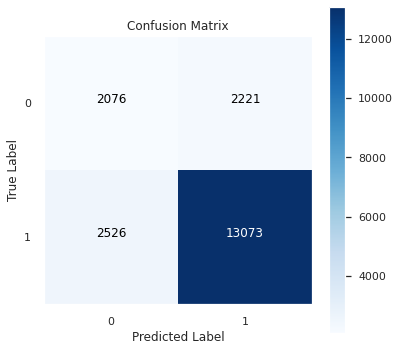

In [ ]:
# Fitting a logistic regression model with default parameters
logreg_us = LogisticRegression(random_state=SEED)
logreg_us.fit(X_train_under_scaled,y_train_under)

# Making predictions
y_hat_train_under = logreg_us.predict(X_train_under_scaled)
y_hat_test_under = logreg_us.predict(X_test_under_scaled)

# Logistic regression scores
print("Logistic regression Undersampled score for training set:", round(logreg_us.score(X_train_under_scaled, y_train_under),5))
print("Logistic regression Undersampled score for test set:", round(logreg_us.score(X_test_under_scaled, y_test_under),5))
print("\nClassification report:")
print(classification_report(y_test_under, y_hat_test_under))
# Confusion matrix
plot_cf(y_test_under, y_hat_test_under)


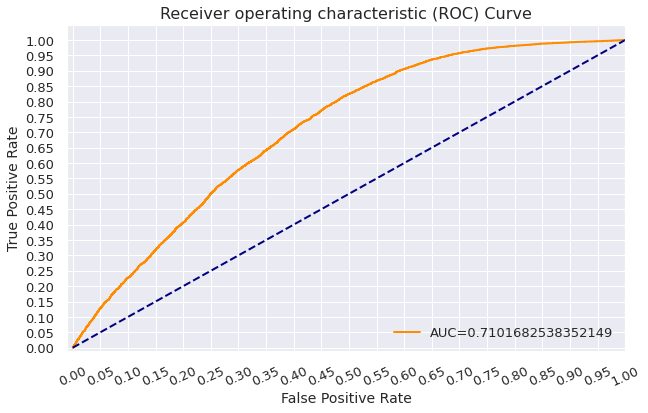

In [ ]:
from sklearn import metrics
lr_us_y_hat_proba = logreg_us.predict_proba(X_test_over_scaled)[::,1]
lr_us_fpr, lr_us_tpr, _ = metrics.roc_curve(y_test_over,  lr_us_y_hat_proba)
lr_us_auc = metrics.roc_auc_score(y_test_over, lr_us_y_hat_proba)

#create ROC curve

from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(10,6))
lw = 2
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.plot(lr_us_fpr,lr_us_tpr, label="AUC="+str(lr_us_auc), color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.yticks([i/20.0 for i in range(21)], fontsize=13)
plt.xticks([i/20.0 for i in range(21)], fontsize=13, rotation = 25)
plt.title('Receiver operating characteristic (ROC) Curve',fontsize=16)
plt.legend(loc=4, fontsize=13)

#from matplotlib.ticker import FormatStrFormatter
#fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

# **Model 7: Random Forest on Undersampled Data**

RF Undersampled score for training set: 0.99963
RF Undersampled score for test set: 0.682

Classification report:
              precision    recall  f1-score   support

           0       0.36      0.61      0.45      4297
           1       0.87      0.70      0.78     15599

    accuracy                           0.68     19896
   macro avg       0.61      0.65      0.61     19896
weighted avg       0.76      0.68      0.71     19896



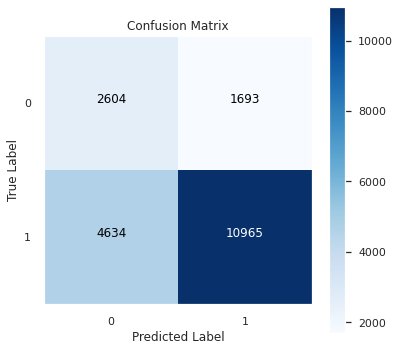

In [ ]:
# Random Forest scores
rf_us = RandomForestClassifier(random_state=SEED).fit(X_train_under_scaled, y_train_under)
y_hat_train2_under = rf_us.predict(X_train_under_scaled)
y_hat_test2_under = rf_us.predict(X_test_under_scaled)
print("RF Undersampled score for training set:", round(rf_us.score(X_train_under_scaled, y_train_under),5))
print("RF Undersampled score for test set:", round(rf_us.score(X_test_under_scaled, y_test_under),5))
print("\nClassification report:")
print(classification_report(y_test_under, y_hat_test2_under))
plot_cf(y_test_under, y_hat_test2_under)

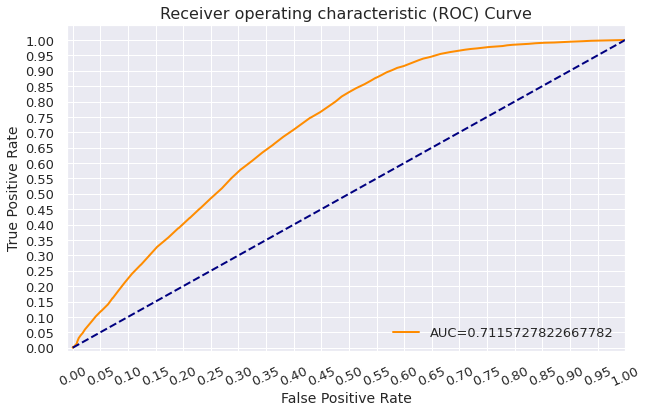

In [ ]:
from sklearn import metrics
rf_us_y_hat_proba = rf_us.predict_proba(X_test_over_scaled)[::,1]
rf_us_fpr, rf_us_tpr, _ = metrics.roc_curve(y_test_over,  rf_us_y_hat_proba)
rf_us_auc = metrics.roc_auc_score(y_test_over, rf_us_y_hat_proba)

#create ROC curve

from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(10,6))
lw = 2
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.plot(rf_us_fpr, rf_us_tpr, label="AUC="+str(rf_us_auc), color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.yticks([i/20.0 for i in range(21)], fontsize=13)
plt.xticks([i/20.0 for i in range(21)], fontsize=13, rotation = 25)
plt.title('Receiver operating characteristic (ROC) Curve',fontsize=16)
plt.legend(loc=4, fontsize=13)

#from matplotlib.ticker import FormatStrFormatter
#fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

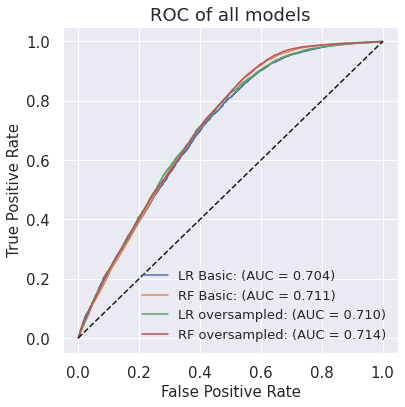

In [ ]:
plt.plot(lr_fpr, lr_tpr, label = 'LR Basic: (AUC = %0.3f)' % lr_auc)
plt.plot(rf_fpr, rf_tpr, label = 'RF Basic: (AUC = %0.3f)' % rf_auc)
#plt.plot(lr_log_fpr, lr_log_tpr, label = 'LR with log transform.: (AUC = %0.3f)' % lr_log_auc)
plt.plot(lr_os_fpr, lr_os_tpr, label = 'LR oversampled: (AUC = %0.3f)'% lr_os_auc)
plt.plot(rf_os_fpr, rf_os_tpr, label = 'RF oversampled: (AUC = %0.3f)'% rf_os_auc)
#plt.plot(lr_us_fpr, lr_us_tpr, label = 'LR undersampled: (AUC = %0.3f)' % lr_us_auc)
#plt.plot(rf_us_fpr, rf_us_tpr, label = 'RF undersampled: (AUC = %0.3f)' % rf_us_auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('ROC of all models', fontsize = 18)
plt.rcParams["figure.figsize"] = (12,6)
plt.legend(loc="lower right", fontsize = 13)
plt.rcParams['figure.facecolor'] = 'none'

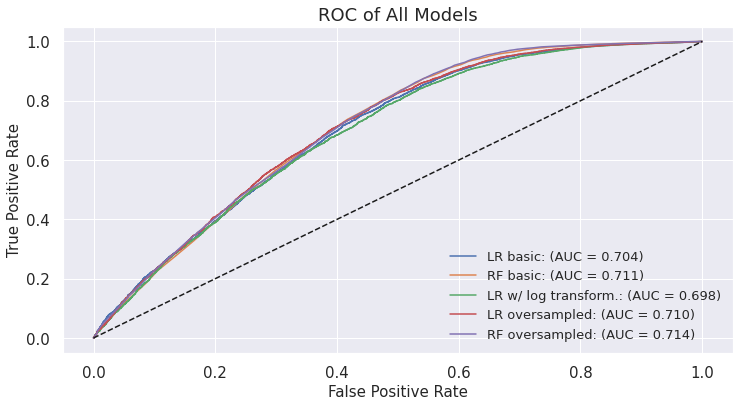

In [ ]:
plt.plot(lr_fpr, lr_tpr, label = 'LR basic: (AUC = %0.3f)' % lr_auc)
plt.plot(rf_fpr, rf_tpr, label = 'RF basic: (AUC = %0.3f)' % rf_auc)
plt.plot(lr_log_fpr, lr_log_tpr, label = 'LR w/ log transform.: (AUC = %0.3f)' % lr_log_auc)
plt.plot(lr_os_fpr, lr_os_tpr, label = 'LR oversampled: (AUC = %0.3f)'% lr_os_auc)
plt.plot(rf_os_fpr, rf_os_tpr, label = 'RF oversampled: (AUC = %0.3f)'% rf_os_auc)
#plt.plot(lr_us_fpr, lr_us_tpr, label = 'LR undersampled: (AUC = %0.3f)' % lr_us_auc)
#plt.plot(rf_us_fpr, rf_us_tpr, label = 'RF undersampled: (AUC = %0.3f)' % rf_us_auc)


#lr_os_auc
#rf_os_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('ROC of All Models', fontsize = 18)
plt.rcParams["figure.figsize"] = (10,6)
plt.legend(loc="lower right", fontsize = 13)